***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las trayectorias con sus respectivas clases en "complete_df" :***

In [2]:
csv_files = [
    "./Trayectorias/Tipos_de_barcos/longitud_8/Cargo_modificado_compressed_8_v3.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Container_modificado_compressed_8_v3.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Cruise_modificado_compressed_8_v3.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Fishing_modificado_compressed_8_v3.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Tanker_modificado_compressed_8_v3.csv"
]

complete_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    df['Bearing'] = df['Bearing'].round(4)
    grouped = df.groupby('Trajectory_ID')['Bearing'].apply(lambda x: [i for i in x if pd.notna(i)]).reset_index()
    grouped['Type'] = file.split('/')[-1].split('_')[0]
    complete_df = pd.concat([complete_df, grouped], ignore_index=True)

### COMPROBACIÓN BEARING ###
for tipo in complete_df['Type'].unique():
    first_element = complete_df[complete_df['Type'] == tipo].iloc[0]
    print(f"Type: {tipo}, Trajectory_ID: {first_element['Trajectory_ID']}, Bearing: {first_element['Bearing']}")

print()

### COMPROBACIÓN NÚMERO DE TRAYECTORIAS ###
print("Número total de trayectorias:", len(complete_df))
class_counts = complete_df['Type'].value_counts()
print(class_counts)

Type: Cargo, Trajectory_ID: 6, Bearing: [96.012, 89.9997, 94.6138, 85.6831, 86.4102, 93.7578, 90.7693]
Type: Container, Trajectory_ID: 4, Bearing: [89.1345, 91.6473, 93.4429, 93.0914, 89.9998, 88.1736, 88.4108]
Type: Cruise, Trajectory_ID: 24, Bearing: [92.832, 85.1854, 91.5421, 86.3841, 90.8329, 89.2838, 85.2497]
Type: Fishing, Trajectory_ID: 19, Bearing: [104.7537, 68.3662, 92.5521, 52.8847, 92.9924, 121.3142, 87.1093]
Type: Tanker, Trajectory_ID: 12, Bearing: [86.2599, 117.1086, 86.6212, 69.9615, 97.2998, 61.1225, 99.9396]

Número total de trayectorias: 3884
Type
Fishing      949
Container    933
Cruise       918
Tanker       688
Cargo        396
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['Type'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['Type'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de trayectorias en train: {len(train_df)}")
print(train_df['Type'].value_counts())
print()
print(f"Nº de trayectorias en test: {len(test_df)}")
print(test_df['Type'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(5))
print()
print("Ejm. conjunto test:")
print(test_df.head(5))

Nº de trayectorias en train: 3110
Type
Fishing      760
Container    747
Cruise       735
Tanker       551
Cargo        317
Name: count, dtype: int64

Nº de trayectorias en test: 774
Type
Fishing      189
Container    186
Cruise       183
Tanker       137
Cargo         79
Name: count, dtype: int64

Ejm. conjunto train:
   Trajectory_ID                                            Bearing    Type
0           4082  [91.7482, 93.7536, 92.6294, 86.937, 87.9144, 8...  Cruise
1           2036  [90.2654, 94.8732, 92.8022, 86.7945, 93.4144, ...  Tanker
2            313  [76.6374, 129.2308, 72.7347, 92.1478, 67.8174,...  Cruise
3           1250  [81.8254, 100.1295, 86.4494, 74.7006, 102.229,...   Cargo
4           1806  [89.6836, 93.1597, 91.4829, 85.9495, 84.9088, ...  Cruise

Ejm. conjunto test:
   Trajectory_ID                                            Bearing       Type
0           3433  [103.031, 65.9458, 94.135, 110.9997, 84.341, 1...    Fishing
1            611  [75.7927, 91.6604, 53.8034

***Pre-procesado de los datos :***

In [4]:
#Convertimos Bearing a un array de numpy
X_train = np.array(train_df['Bearing'].tolist())
X_test = np.array(test_df['Bearing'].tolist())

#Normalizamos los valores de Bearing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Añadimos una dimensión extra para que tenga la forma (n, 1)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

#Codificamos las etiquetas de Type
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Type'])
y_test = label_encoder.transform(test_df['Type'])

#Conversión a tensores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)

Device: cuda
X_train: torch.Size([3110, 1, 7]) cuda:0
y_train: torch.Size([3110]) cuda:0
X_test: torch.Size([774, 1, 7]) cuda:0
y_test: torch.Size([774]) cuda:0


# ***CNN1D :***

In [5]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (X_train.shape[2] // 4), 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

***Configuración del modelo :***

In [6]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 5

***Entrenamiento del modelo :***

In [7]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNN1D(num_classes=num_classes).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v3/representacion_1/longitud_8"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/CNN1D_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 78/78 [00:03<00:00, 22.01it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 20.78% - Train Loss: 1.6121 | Val Acc: 24.12% - Val Loss: 1.6096


Fold 1 | Epoch 2/100: 100%|██████████| 78/78 [00:00<00:00, 392.77it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 22.07% - Train Loss: 1.6101 | Val Acc: 16.24% - Val Loss: 1.6108


Fold 1 | Epoch 3/100: 100%|██████████| 78/78 [00:00<00:00, 374.37it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 21.34% - Train Loss: 1.6100 | Val Acc: 16.56% - Val Loss: 1.6102


Fold 1 | Epoch 4/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 20.74% - Train Loss: 1.6098 | Val Acc: 24.76% - Val Loss: 1.6102


Fold 1 | Epoch 5/100: 100%|██████████| 78/78 [00:00<00:00, 382.36it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 22.59% - Train Loss: 1.6085 | Val Acc: 23.95% - Val Loss: 1.6120


Fold 1 | Epoch 6/100: 100%|██████████| 78/78 [00:00<00:00, 339.35it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 23.63% - Train Loss: 1.6074 | Val Acc: 26.69% - Val Loss: 1.6082


Fold 1 | Epoch 7/100: 100%|██████████| 78/78 [00:00<00:00, 354.47it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 23.31% - Train Loss: 1.6058 | Val Acc: 25.88% - Val Loss: 1.6052


Fold 1 | Epoch 8/100: 100%|██████████| 78/78 [00:00<00:00, 377.65it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 23.75% - Train Loss: 1.6037 | Val Acc: 22.51% - Val Loss: 1.6038


Fold 1 | Epoch 9/100: 100%|██████████| 78/78 [00:00<00:00, 369.91it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 24.20% - Train Loss: 1.6040 | Val Acc: 26.05% - Val Loss: 1.6030


Fold 1 | Epoch 10/100: 100%|██████████| 78/78 [00:00<00:00, 336.70it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 24.04% - Train Loss: 1.6020 | Val Acc: 25.72% - Val Loss: 1.6024


Fold 1 | Epoch 11/100: 100%|██████████| 78/78 [00:00<00:00, 345.87it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 25.24% - Train Loss: 1.6032 | Val Acc: 26.53% - Val Loss: 1.6082


Fold 1 | Epoch 12/100: 100%|██████████| 78/78 [00:00<00:00, 384.88it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 25.60% - Train Loss: 1.5992 | Val Acc: 26.37% - Val Loss: 1.6038


Fold 1 | Epoch 13/100: 100%|██████████| 78/78 [00:00<00:00, 389.70it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 24.56% - Train Loss: 1.5980 | Val Acc: 28.62% - Val Loss: 1.6034


Fold 1 | Epoch 14/100: 100%|██████████| 78/78 [00:00<00:00, 378.23it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 24.88% - Train Loss: 1.5985 | Val Acc: 27.49% - Val Loss: 1.6048


Fold 1 | Epoch 15/100: 100%|██████████| 78/78 [00:00<00:00, 349.26it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 25.16% - Train Loss: 1.5998 | Val Acc: 27.49% - Val Loss: 1.6057


Fold 1 | Epoch 16/100: 100%|██████████| 78/78 [00:00<00:00, 353.72it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 25.00% - Train Loss: 1.5990 | Val Acc: 18.97% - Val Loss: 1.6045


Fold 1 | Epoch 17/100: 100%|██████████| 78/78 [00:00<00:00, 381.59it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 20.66% - Train Loss: 1.5966 | Val Acc: 27.81% - Val Loss: 1.6061


Fold 1 | Epoch 18/100: 100%|██████████| 78/78 [00:00<00:00, 350.69it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 25.52% - Train Loss: 1.5952 | Val Acc: 18.33% - Val Loss: 1.6052


Fold 1 | Epoch 19/100: 100%|██████████| 78/78 [00:00<00:00, 392.95it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 21.70% - Train Loss: 1.5980 | Val Acc: 25.72% - Val Loss: 1.6121


Fold 1 | Epoch 20/100: 100%|██████████| 78/78 [00:00<00:00, 400.04it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 23.15% - Train Loss: 1.5962 | Val Acc: 21.22% - Val Loss: 1.6083


Fold 1 | Epoch 21/100: 100%|██████████| 78/78 [00:00<00:00, 386.14it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 24.12% - Train Loss: 1.5932 | Val Acc: 22.99% - Val Loss: 1.6073


Fold 1 | Epoch 22/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 20.94% - Train Loss: 1.5947 | Val Acc: 27.81% - Val Loss: 1.6067


Fold 1 | Epoch 23/100: 100%|██████████| 78/78 [00:00<00:00, 332.10it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 22.71% - Train Loss: 1.5922 | Val Acc: 27.01% - Val Loss: 1.6077


Fold 1 | Epoch 24/100: 100%|██████████| 78/78 [00:00<00:00, 368.33it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 22.07% - Train Loss: 1.5940 | Val Acc: 18.65% - Val Loss: 1.6040


Fold 1 | Epoch 25/100: 100%|██████████| 78/78 [00:00<00:00, 369.68it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 24.32% - Train Loss: 1.5916 | Val Acc: 20.90% - Val Loss: 1.6060


Fold 1 | Epoch 26/100: 100%|██████████| 78/78 [00:00<00:00, 385.42it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 22.79% - Train Loss: 1.5928 | Val Acc: 14.47% - Val Loss: 1.6085


Fold 1 | Epoch 27/100: 100%|██████████| 78/78 [00:00<00:00, 386.81it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 22.75% - Train Loss: 1.5925 | Val Acc: 18.97% - Val Loss: 1.6053


Fold 1 | Epoch 28/100: 100%|██████████| 78/78 [00:00<00:00, 386.14it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 23.47% - Train Loss: 1.5902 | Val Acc: 23.95% - Val Loss: 1.6058


Fold 1 | Epoch 29/100: 100%|██████████| 78/78 [00:00<00:00, 396.75it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 23.03% - Train Loss: 1.5905 | Val Acc: 22.67% - Val Loss: 1.6071


Fold 1 | Epoch 30/100: 100%|██████████| 78/78 [00:00<00:00, 393.84it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 24.96% - Train Loss: 1.5899 | Val Acc: 22.03% - Val Loss: 1.6061


Fold 1 | Epoch 31/100: 100%|██████████| 78/78 [00:00<00:00, 395.47it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 23.43% - Train Loss: 1.5901 | Val Acc: 21.22% - Val Loss: 1.6116


Fold 1 | Epoch 32/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 25.20% - Train Loss: 1.5873 | Val Acc: 18.97% - Val Loss: 1.6061


Fold 1 | Epoch 33/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 23.55% - Train Loss: 1.5871 | Val Acc: 25.08% - Val Loss: 1.6044


Fold 1 | Epoch 34/100: 100%|██████████| 78/78 [00:00<00:00, 367.93it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 24.32% - Train Loss: 1.5855 | Val Acc: 23.31% - Val Loss: 1.6076


Fold 1 | Epoch 35/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 25.24% - Train Loss: 1.5836 | Val Acc: 18.65% - Val Loss: 1.6056


Fold 1 | Epoch 36/100: 100%|██████████| 78/78 [00:00<00:00, 392.81it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 24.80% - Train Loss: 1.5836 | Val Acc: 16.72% - Val Loss: 1.6071


Fold 1 | Epoch 37/100: 100%|██████████| 78/78 [00:00<00:00, 393.33it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 23.43% - Train Loss: 1.5833 | Val Acc: 25.24% - Val Loss: 1.6083


Fold 1 | Epoch 38/100: 100%|██████████| 78/78 [00:00<00:00, 389.76it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 25.20% - Train Loss: 1.5812 | Val Acc: 16.08% - Val Loss: 1.6072


Fold 1 | Epoch 39/100: 100%|██████████| 78/78 [00:00<00:00, 386.14it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 24.12% - Train Loss: 1.5822 | Val Acc: 20.10% - Val Loss: 1.6093


Fold 1 | Epoch 40/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 25.84% - Train Loss: 1.5830 | Val Acc: 21.86% - Val Loss: 1.6055


Fold 1 | Epoch 41/100: 100%|██████████| 78/78 [00:00<00:00, 400.00it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 23.55% - Train Loss: 1.5800 | Val Acc: 22.83% - Val Loss: 1.6115


Fold 1 | Epoch 42/100: 100%|██████████| 78/78 [00:00<00:00, 393.68it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 24.84% - Train Loss: 1.5831 | Val Acc: 20.10% - Val Loss: 1.6036


Fold 1 | Epoch 43/100: 100%|██████████| 78/78 [00:00<00:00, 391.97it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 24.00% - Train Loss: 1.5810 | Val Acc: 26.05% - Val Loss: 1.6097


Fold 1 | Epoch 44/100: 100%|██████████| 78/78 [00:00<00:00, 363.15it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 26.33% - Train Loss: 1.5764 | Val Acc: 24.12% - Val Loss: 1.6040


Fold 1 | Epoch 45/100: 100%|██████████| 78/78 [00:00<00:00, 397.96it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 23.91% - Train Loss: 1.5764 | Val Acc: 25.88% - Val Loss: 1.6083


Fold 1 | Epoch 46/100: 100%|██████████| 78/78 [00:00<00:00, 400.00it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 25.28% - Train Loss: 1.5750 | Val Acc: 21.86% - Val Loss: 1.6053


Fold 1 | Epoch 47/100: 100%|██████████| 78/78 [00:00<00:00, 390.23it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 25.16% - Train Loss: 1.5794 | Val Acc: 23.95% - Val Loss: 1.6014


Fold 1 | Epoch 48/100: 100%|██████████| 78/78 [00:00<00:00, 373.76it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 25.48% - Train Loss: 1.5713 | Val Acc: 18.33% - Val Loss: 1.6003


Fold 1 | Epoch 49/100: 100%|██████████| 78/78 [00:00<00:00, 400.96it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 24.80% - Train Loss: 1.5729 | Val Acc: 24.28% - Val Loss: 1.6017


Fold 1 | Epoch 50/100: 100%|██████████| 78/78 [00:00<00:00, 390.52it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 24.92% - Train Loss: 1.5736 | Val Acc: 22.35% - Val Loss: 1.6023


Fold 1 | Epoch 51/100: 100%|██████████| 78/78 [00:00<00:00, 400.04it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 25.44% - Train Loss: 1.5703 | Val Acc: 22.67% - Val Loss: 1.6022


Fold 1 | Epoch 52/100: 100%|██████████| 78/78 [00:00<00:00, 400.00it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 25.68% - Train Loss: 1.5701 | Val Acc: 20.90% - Val Loss: 1.6039


Fold 1 | Epoch 53/100: 100%|██████████| 78/78 [00:00<00:00, 378.93it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 25.88% - Train Loss: 1.5657 | Val Acc: 23.63% - Val Loss: 1.6004


Fold 1 | Epoch 54/100: 100%|██████████| 78/78 [00:00<00:00, 396.03it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 26.33% - Train Loss: 1.5694 | Val Acc: 20.90% - Val Loss: 1.6007


Fold 1 | Epoch 55/100: 100%|██████████| 78/78 [00:00<00:00, 350.90it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 27.73% - Train Loss: 1.5642 | Val Acc: 25.88% - Val Loss: 1.6142


Fold 1 | Epoch 56/100: 100%|██████████| 78/78 [00:00<00:00, 397.16it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 26.33% - Train Loss: 1.5618 | Val Acc: 22.35% - Val Loss: 1.6077


Fold 1 | Epoch 57/100: 100%|██████████| 78/78 [00:00<00:00, 395.91it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 26.57% - Train Loss: 1.5654 | Val Acc: 17.04% - Val Loss: 1.6042


Fold 1 | Epoch 58/100: 100%|██████████| 78/78 [00:00<00:00, 400.00it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 25.60% - Train Loss: 1.5657 | Val Acc: 24.60% - Val Loss: 1.6067


Fold 1 | Epoch 59/100: 100%|██████████| 78/78 [00:00<00:00, 391.59it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 26.00% - Train Loss: 1.5619 | Val Acc: 23.95% - Val Loss: 1.6041


Fold 1 | Epoch 60/100: 100%|██████████| 78/78 [00:00<00:00, 397.96it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 26.53% - Train Loss: 1.5646 | Val Acc: 22.99% - Val Loss: 1.6002


Fold 1 | Epoch 61/100: 100%|██████████| 78/78 [00:00<00:00, 400.03it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 28.05% - Train Loss: 1.5586 | Val Acc: 21.22% - Val Loss: 1.6069


Fold 1 | Epoch 62/100: 100%|██████████| 78/78 [00:00<00:00, 394.17it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 26.89% - Train Loss: 1.5547 | Val Acc: 21.54% - Val Loss: 1.6062


Fold 1 | Epoch 63/100: 100%|██████████| 78/78 [00:00<00:00, 392.99it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 26.85% - Train Loss: 1.5590 | Val Acc: 19.61% - Val Loss: 1.6008


Fold 1 | Epoch 64/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 26.05% - Train Loss: 1.5524 | Val Acc: 19.94% - Val Loss: 1.6126


Fold 1 | Epoch 65/100: 100%|██████████| 78/78 [00:00<00:00, 339.13it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 27.17% - Train Loss: 1.5540 | Val Acc: 25.08% - Val Loss: 1.6171


Fold 1 | Epoch 66/100: 100%|██████████| 78/78 [00:00<00:00, 375.00it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 26.81% - Train Loss: 1.5549 | Val Acc: 15.27% - Val Loss: 1.6141


Fold 1 | Epoch 67/100: 100%|██████████| 78/78 [00:00<00:00, 395.42it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 26.45% - Train Loss: 1.5524 | Val Acc: 17.20% - Val Loss: 1.6071


Fold 1 | Epoch 68/100: 100%|██████████| 78/78 [00:00<00:00, 379.88it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 28.22% - Train Loss: 1.5470 | Val Acc: 25.56% - Val Loss: 1.6103


Fold 1 | Epoch 69/100: 100%|██████████| 78/78 [00:00<00:00, 393.87it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 27.77% - Train Loss: 1.5480 | Val Acc: 21.54% - Val Loss: 1.6021


Fold 1 | Epoch 70/100: 100%|██████████| 78/78 [00:00<00:00, 404.48it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 28.86% - Train Loss: 1.5442 | Val Acc: 21.06% - Val Loss: 1.6111


Fold 1 | Epoch 71/100: 100%|██████████| 78/78 [00:00<00:00, 404.14it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 27.29% - Train Loss: 1.5429 | Val Acc: 23.15% - Val Loss: 1.6149


Fold 1 | Epoch 72/100: 100%|██████████| 78/78 [00:00<00:00, 392.95it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 28.86% - Train Loss: 1.5410 | Val Acc: 16.72% - Val Loss: 1.6145


Fold 1 | Epoch 73/100: 100%|██████████| 78/78 [00:00<00:00, 385.32it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 28.34% - Train Loss: 1.5414 | Val Acc: 17.36% - Val Loss: 1.6193


Fold 1 | Epoch 74/100: 100%|██████████| 78/78 [00:00<00:00, 390.24it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 29.42% - Train Loss: 1.5360 | Val Acc: 24.12% - Val Loss: 1.6098


Fold 1 | Epoch 75/100: 100%|██████████| 78/78 [00:00<00:00, 390.24it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 27.77% - Train Loss: 1.5369 | Val Acc: 22.67% - Val Loss: 1.6062


Fold 1 | Epoch 76/100: 100%|██████████| 78/78 [00:00<00:00, 351.35it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 28.78% - Train Loss: 1.5381 | Val Acc: 25.08% - Val Loss: 1.6112


Fold 1 | Epoch 77/100: 100%|██████████| 78/78 [00:00<00:00, 373.21it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 27.53% - Train Loss: 1.5342 | Val Acc: 24.60% - Val Loss: 1.6331


Fold 1 | Epoch 78/100: 100%|██████████| 78/78 [00:00<00:00, 377.04it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 29.06% - Train Loss: 1.5335 | Val Acc: 23.47% - Val Loss: 1.6098


Fold 1 | Epoch 79/100: 100%|██████████| 78/78 [00:00<00:00, 383.54it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 28.50% - Train Loss: 1.5336 | Val Acc: 23.47% - Val Loss: 1.6125


Fold 1 | Epoch 80/100: 100%|██████████| 78/78 [00:00<00:00, 392.19it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 29.38% - Train Loss: 1.5252 | Val Acc: 25.56% - Val Loss: 1.6444


Fold 1 | Epoch 81/100: 100%|██████████| 78/78 [00:00<00:00, 380.49it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 29.14% - Train Loss: 1.5338 | Val Acc: 24.28% - Val Loss: 1.6194


Fold 1 | Epoch 82/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 30.06% - Train Loss: 1.5271 | Val Acc: 24.28% - Val Loss: 1.6146


Fold 1 | Epoch 83/100: 100%|██████████| 78/78 [00:00<00:00, 397.96it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 30.02% - Train Loss: 1.5245 | Val Acc: 22.03% - Val Loss: 1.6104


Fold 1 | Epoch 84/100: 100%|██████████| 78/78 [00:00<00:00, 390.00it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 30.35% - Train Loss: 1.5246 | Val Acc: 25.08% - Val Loss: 1.6274


Fold 1 | Epoch 85/100: 100%|██████████| 78/78 [00:00<00:00, 381.88it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 28.58% - Train Loss: 1.5264 | Val Acc: 20.90% - Val Loss: 1.6172


Fold 1 | Epoch 86/100: 100%|██████████| 78/78 [00:00<00:00, 336.21it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 28.74% - Train Loss: 1.5283 | Val Acc: 18.65% - Val Loss: 1.6117


Fold 1 | Epoch 87/100: 100%|██████████| 78/78 [00:00<00:00, 373.46it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 29.50% - Train Loss: 1.5140 | Val Acc: 22.99% - Val Loss: 1.6150


Fold 1 | Epoch 88/100: 100%|██████████| 78/78 [00:00<00:00, 387.17it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 30.55% - Train Loss: 1.5209 | Val Acc: 19.13% - Val Loss: 1.6191


Fold 1 | Epoch 89/100: 100%|██████████| 78/78 [00:00<00:00, 391.55it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 29.50% - Train Loss: 1.5194 | Val Acc: 22.67% - Val Loss: 1.6213


Fold 1 | Epoch 90/100: 100%|██████████| 78/78 [00:00<00:00, 385.30it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 30.06% - Train Loss: 1.5152 | Val Acc: 23.63% - Val Loss: 1.6183


Fold 1 | Epoch 91/100: 100%|██████████| 78/78 [00:00<00:00, 359.82it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 30.63% - Train Loss: 1.5127 | Val Acc: 24.44% - Val Loss: 1.6258


Fold 1 | Epoch 92/100: 100%|██████████| 78/78 [00:00<00:00, 375.53it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 30.27% - Train Loss: 1.5169 | Val Acc: 24.76% - Val Loss: 1.6262


Fold 1 | Epoch 93/100: 100%|██████████| 78/78 [00:00<00:00, 393.49it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 30.63% - Train Loss: 1.5096 | Val Acc: 25.08% - Val Loss: 1.6416


Fold 1 | Epoch 94/100: 100%|██████████| 78/78 [00:00<00:00, 377.01it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 29.82% - Train Loss: 1.5127 | Val Acc: 25.40% - Val Loss: 1.6383


Fold 1 | Epoch 95/100: 100%|██████████| 78/78 [00:00<00:00, 390.37it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 30.10% - Train Loss: 1.5159 | Val Acc: 23.63% - Val Loss: 1.6189


Fold 1 | Epoch 96/100: 100%|██████████| 78/78 [00:00<00:00, 367.67it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 31.59% - Train Loss: 1.5070 | Val Acc: 22.67% - Val Loss: 1.6161


Fold 1 | Epoch 97/100: 100%|██████████| 78/78 [00:00<00:00, 390.93it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 30.87% - Train Loss: 1.5051 | Val Acc: 18.97% - Val Loss: 1.6279


Fold 1 | Epoch 98/100: 100%|██████████| 78/78 [00:00<00:00, 394.58it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 30.51% - Train Loss: 1.5045 | Val Acc: 25.88% - Val Loss: 1.6295


Fold 1 | Epoch 99/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 31.83% - Train Loss: 1.4973 | Val Acc: 25.88% - Val Loss: 1.6368


Fold 1 | Epoch 100/100: 100%|██████████| 78/78 [00:00<00:00, 397.76it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 30.79% - Train Loss: 1.4995 | Val Acc: 27.17% - Val Loss: 1.6334

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 78/78 [00:00<00:00, 381.61it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 23.15% - Train Loss: 1.6121 | Val Acc: 22.99% - Val Loss: 1.6130


Fold 2 | Epoch 2/100: 100%|██████████| 78/78 [00:00<00:00, 401.34it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 24.40% - Train Loss: 1.6098 | Val Acc: 23.63% - Val Loss: 1.6102


Fold 2 | Epoch 3/100: 100%|██████████| 78/78 [00:00<00:00, 389.38it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 24.36% - Train Loss: 1.6098 | Val Acc: 22.99% - Val Loss: 1.6124


Fold 2 | Epoch 4/100: 100%|██████████| 78/78 [00:00<00:00, 395.45it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 24.32% - Train Loss: 1.6097 | Val Acc: 26.05% - Val Loss: 1.6102


Fold 2 | Epoch 5/100: 100%|██████████| 78/78 [00:00<00:00, 398.39it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 24.08% - Train Loss: 1.6086 | Val Acc: 22.99% - Val Loss: 1.6098


Fold 2 | Epoch 6/100: 100%|██████████| 78/78 [00:00<00:00, 317.07it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 25.08% - Train Loss: 1.6073 | Val Acc: 22.99% - Val Loss: 1.6120


Fold 2 | Epoch 7/100: 100%|██████████| 78/78 [00:00<00:00, 386.22it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 24.72% - Train Loss: 1.6075 | Val Acc: 27.01% - Val Loss: 1.6061


Fold 2 | Epoch 8/100: 100%|██████████| 78/78 [00:00<00:00, 383.17it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 25.92% - Train Loss: 1.6029 | Val Acc: 23.63% - Val Loss: 1.6165


Fold 2 | Epoch 9/100: 100%|██████████| 78/78 [00:00<00:00, 391.43it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 26.49% - Train Loss: 1.6022 | Val Acc: 22.19% - Val Loss: 1.6048


Fold 2 | Epoch 10/100: 100%|██████████| 78/78 [00:00<00:00, 380.49it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 25.00% - Train Loss: 1.6030 | Val Acc: 25.56% - Val Loss: 1.5990


Fold 2 | Epoch 11/100: 100%|██████████| 78/78 [00:00<00:00, 394.11it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 25.48% - Train Loss: 1.6020 | Val Acc: 28.14% - Val Loss: 1.5992


Fold 2 | Epoch 12/100: 100%|██████████| 78/78 [00:00<00:00, 384.23it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 25.88% - Train Loss: 1.6026 | Val Acc: 26.53% - Val Loss: 1.6007


Fold 2 | Epoch 13/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 25.48% - Train Loss: 1.6002 | Val Acc: 27.33% - Val Loss: 1.6014


Fold 2 | Epoch 14/100: 100%|██████████| 78/78 [00:00<00:00, 397.23it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 25.36% - Train Loss: 1.5994 | Val Acc: 23.79% - Val Loss: 1.5999


Fold 2 | Epoch 15/100: 100%|██████████| 78/78 [00:00<00:00, 387.61it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 26.00% - Train Loss: 1.5996 | Val Acc: 26.85% - Val Loss: 1.5973


Fold 2 | Epoch 16/100: 100%|██████████| 78/78 [00:00<00:00, 364.48it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 23.35% - Train Loss: 1.5975 | Val Acc: 23.95% - Val Loss: 1.5961


Fold 2 | Epoch 17/100: 100%|██████████| 78/78 [00:00<00:00, 392.17it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 25.88% - Train Loss: 1.5984 | Val Acc: 27.81% - Val Loss: 1.5978


Fold 2 | Epoch 18/100: 100%|██████████| 78/78 [00:00<00:00, 395.41it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 25.16% - Train Loss: 1.5963 | Val Acc: 25.72% - Val Loss: 1.5955


Fold 2 | Epoch 19/100: 100%|██████████| 78/78 [00:00<00:00, 390.74it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 25.96% - Train Loss: 1.5967 | Val Acc: 26.21% - Val Loss: 1.5980


Fold 2 | Epoch 20/100: 100%|██████████| 78/78 [00:00<00:00, 390.98it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 25.76% - Train Loss: 1.5957 | Val Acc: 21.06% - Val Loss: 1.5938


Fold 2 | Epoch 21/100: 100%|██████████| 78/78 [00:00<00:00, 374.82it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 25.44% - Train Loss: 1.5934 | Val Acc: 22.83% - Val Loss: 1.5948


Fold 2 | Epoch 22/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 24.36% - Train Loss: 1.5917 | Val Acc: 24.76% - Val Loss: 1.5989


Fold 2 | Epoch 23/100: 100%|██████████| 78/78 [00:00<00:00, 391.75it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 25.80% - Train Loss: 1.5921 | Val Acc: 26.85% - Val Loss: 1.5987


Fold 2 | Epoch 24/100: 100%|██████████| 78/78 [00:00<00:00, 391.08it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 26.09% - Train Loss: 1.5898 | Val Acc: 23.47% - Val Loss: 1.5968


Fold 2 | Epoch 25/100: 100%|██████████| 78/78 [00:00<00:00, 388.56it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 23.95% - Train Loss: 1.5934 | Val Acc: 25.56% - Val Loss: 1.6029


Fold 2 | Epoch 26/100: 100%|██████████| 78/78 [00:00<00:00, 362.82it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 27.33% - Train Loss: 1.5864 | Val Acc: 20.10% - Val Loss: 1.5933


Fold 2 | Epoch 27/100: 100%|██████████| 78/78 [00:00<00:00, 396.00it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 26.29% - Train Loss: 1.5882 | Val Acc: 24.44% - Val Loss: 1.5936


Fold 2 | Epoch 28/100: 100%|██████████| 78/78 [00:00<00:00, 380.67it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 25.80% - Train Loss: 1.5867 | Val Acc: 25.24% - Val Loss: 1.5967


Fold 2 | Epoch 29/100: 100%|██████████| 78/78 [00:00<00:00, 389.47it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 26.37% - Train Loss: 1.5838 | Val Acc: 23.79% - Val Loss: 1.5975


Fold 2 | Epoch 30/100: 100%|██████████| 78/78 [00:00<00:00, 392.37it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 26.37% - Train Loss: 1.5837 | Val Acc: 25.08% - Val Loss: 1.5966


Fold 2 | Epoch 31/100: 100%|██████████| 78/78 [00:00<00:00, 390.52it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 24.64% - Train Loss: 1.5798 | Val Acc: 25.40% - Val Loss: 1.5977


Fold 2 | Epoch 32/100: 100%|██████████| 78/78 [00:00<00:00, 374.12it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 27.01% - Train Loss: 1.5796 | Val Acc: 25.08% - Val Loss: 1.5964


Fold 2 | Epoch 33/100: 100%|██████████| 78/78 [00:00<00:00, 389.54it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 26.57% - Train Loss: 1.5776 | Val Acc: 18.65% - Val Loss: 1.5959


Fold 2 | Epoch 34/100: 100%|██████████| 78/78 [00:00<00:00, 401.72it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 27.61% - Train Loss: 1.5745 | Val Acc: 18.33% - Val Loss: 1.5932


Fold 2 | Epoch 35/100: 100%|██████████| 78/78 [00:00<00:00, 355.38it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 25.96% - Train Loss: 1.5728 | Val Acc: 21.22% - Val Loss: 1.6043


Fold 2 | Epoch 36/100: 100%|██████████| 78/78 [00:00<00:00, 392.80it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 27.05% - Train Loss: 1.5737 | Val Acc: 20.42% - Val Loss: 1.5974


Fold 2 | Epoch 37/100: 100%|██████████| 78/78 [00:00<00:00, 393.81it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 25.88% - Train Loss: 1.5726 | Val Acc: 25.24% - Val Loss: 1.6028


Fold 2 | Epoch 38/100: 100%|██████████| 78/78 [00:00<00:00, 388.85it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 26.33% - Train Loss: 1.5700 | Val Acc: 24.28% - Val Loss: 1.6004


Fold 2 | Epoch 39/100: 100%|██████████| 78/78 [00:00<00:00, 384.84it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 27.09% - Train Loss: 1.5668 | Val Acc: 25.72% - Val Loss: 1.6081


Fold 2 | Epoch 40/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 27.61% - Train Loss: 1.5680 | Val Acc: 21.22% - Val Loss: 1.5969


Fold 2 | Epoch 41/100: 100%|██████████| 78/78 [00:00<00:00, 378.89it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 25.92% - Train Loss: 1.5635 | Val Acc: 22.03% - Val Loss: 1.6022


Fold 2 | Epoch 42/100: 100%|██████████| 78/78 [00:00<00:00, 392.83it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 27.21% - Train Loss: 1.5638 | Val Acc: 18.97% - Val Loss: 1.6016


Fold 2 | Epoch 43/100: 100%|██████████| 78/78 [00:00<00:00, 394.57it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 26.97% - Train Loss: 1.5581 | Val Acc: 21.54% - Val Loss: 1.6022


Fold 2 | Epoch 44/100: 100%|██████████| 78/78 [00:00<00:00, 361.31it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 27.85% - Train Loss: 1.5582 | Val Acc: 24.92% - Val Loss: 1.6033


Fold 2 | Epoch 45/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 28.09% - Train Loss: 1.5527 | Val Acc: 26.21% - Val Loss: 1.6063


Fold 2 | Epoch 46/100: 100%|██████████| 78/78 [00:00<00:00, 392.33it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 28.09% - Train Loss: 1.5518 | Val Acc: 22.99% - Val Loss: 1.6034


Fold 2 | Epoch 47/100: 100%|██████████| 78/78 [00:00<00:00, 387.78it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 28.26% - Train Loss: 1.5558 | Val Acc: 25.24% - Val Loss: 1.6034


Fold 2 | Epoch 48/100: 100%|██████████| 78/78 [00:00<00:00, 386.94it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 27.85% - Train Loss: 1.5526 | Val Acc: 19.45% - Val Loss: 1.5999


Fold 2 | Epoch 49/100: 100%|██████████| 78/78 [00:00<00:00, 387.74it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 28.94% - Train Loss: 1.5486 | Val Acc: 27.17% - Val Loss: 1.6136


Fold 2 | Epoch 50/100: 100%|██████████| 78/78 [00:00<00:00, 376.81it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 29.74% - Train Loss: 1.5478 | Val Acc: 26.05% - Val Loss: 1.6063


Fold 2 | Epoch 51/100: 100%|██████████| 78/78 [00:00<00:00, 390.00it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 27.41% - Train Loss: 1.5484 | Val Acc: 22.19% - Val Loss: 1.6004


Fold 2 | Epoch 52/100: 100%|██████████| 78/78 [00:00<00:00, 383.21it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 29.06% - Train Loss: 1.5412 | Val Acc: 25.08% - Val Loss: 1.6131


Fold 2 | Epoch 53/100: 100%|██████████| 78/78 [00:00<00:00, 362.79it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 29.86% - Train Loss: 1.5396 | Val Acc: 23.31% - Val Loss: 1.5990


Fold 2 | Epoch 54/100: 100%|██████████| 78/78 [00:00<00:00, 359.45it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 28.74% - Train Loss: 1.5402 | Val Acc: 26.21% - Val Loss: 1.6143


Fold 2 | Epoch 55/100: 100%|██████████| 78/78 [00:00<00:00, 384.18it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 29.86% - Train Loss: 1.5358 | Val Acc: 21.06% - Val Loss: 1.6038


Fold 2 | Epoch 56/100: 100%|██████████| 78/78 [00:00<00:00, 393.29it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 27.41% - Train Loss: 1.5404 | Val Acc: 24.92% - Val Loss: 1.6094


Fold 2 | Epoch 57/100: 100%|██████████| 78/78 [00:00<00:00, 385.11it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 29.10% - Train Loss: 1.5358 | Val Acc: 22.83% - Val Loss: 1.6107


Fold 2 | Epoch 58/100: 100%|██████████| 78/78 [00:00<00:00, 394.09it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 30.55% - Train Loss: 1.5309 | Val Acc: 24.28% - Val Loss: 1.6141


Fold 2 | Epoch 59/100: 100%|██████████| 78/78 [00:00<00:00, 383.41it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 29.66% - Train Loss: 1.5251 | Val Acc: 24.44% - Val Loss: 1.6128


Fold 2 | Epoch 60/100: 100%|██████████| 78/78 [00:00<00:00, 369.67it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 29.30% - Train Loss: 1.5286 | Val Acc: 27.65% - Val Loss: 1.6128


Fold 2 | Epoch 61/100: 100%|██████████| 78/78 [00:00<00:00, 373.00it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 30.47% - Train Loss: 1.5239 | Val Acc: 24.28% - Val Loss: 1.6148


Fold 2 | Epoch 62/100: 100%|██████████| 78/78 [00:00<00:00, 395.76it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 28.74% - Train Loss: 1.5226 | Val Acc: 25.88% - Val Loss: 1.6197


Fold 2 | Epoch 63/100: 100%|██████████| 78/78 [00:00<00:00, 383.68it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 31.55% - Train Loss: 1.5150 | Val Acc: 21.70% - Val Loss: 1.6088


Fold 2 | Epoch 64/100: 100%|██████████| 78/78 [00:00<00:00, 355.15it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 29.46% - Train Loss: 1.5147 | Val Acc: 22.99% - Val Loss: 1.6244


Fold 2 | Epoch 65/100: 100%|██████████| 78/78 [00:00<00:00, 392.05it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 31.11% - Train Loss: 1.5133 | Val Acc: 26.37% - Val Loss: 1.6146


Fold 2 | Epoch 66/100: 100%|██████████| 78/78 [00:00<00:00, 400.02it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 31.23% - Train Loss: 1.5093 | Val Acc: 24.44% - Val Loss: 1.6254


Fold 2 | Epoch 67/100: 100%|██████████| 78/78 [00:00<00:00, 375.68it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 30.79% - Train Loss: 1.5091 | Val Acc: 21.22% - Val Loss: 1.6202


Fold 2 | Epoch 68/100: 100%|██████████| 78/78 [00:00<00:00, 366.20it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 31.47% - Train Loss: 1.5119 | Val Acc: 27.17% - Val Loss: 1.6285


Fold 2 | Epoch 69/100: 100%|██████████| 78/78 [00:00<00:00, 396.06it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 31.15% - Train Loss: 1.5076 | Val Acc: 22.67% - Val Loss: 1.6251


Fold 2 | Epoch 70/100: 100%|██████████| 78/78 [00:00<00:00, 383.83it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 30.75% - Train Loss: 1.5065 | Val Acc: 25.24% - Val Loss: 1.6229


Fold 2 | Epoch 71/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 31.91% - Train Loss: 1.4958 | Val Acc: 25.56% - Val Loss: 1.6193


Fold 2 | Epoch 72/100: 100%|██████████| 78/78 [00:00<00:00, 388.47it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 30.10% - Train Loss: 1.5000 | Val Acc: 24.12% - Val Loss: 1.6225


Fold 2 | Epoch 73/100: 100%|██████████| 78/78 [00:00<00:00, 396.12it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 31.47% - Train Loss: 1.4975 | Val Acc: 23.15% - Val Loss: 1.6108


Fold 2 | Epoch 74/100: 100%|██████████| 78/78 [00:00<00:00, 349.77it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 31.11% - Train Loss: 1.4950 | Val Acc: 21.38% - Val Loss: 1.6150


Fold 2 | Epoch 75/100: 100%|██████████| 78/78 [00:00<00:00, 396.54it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 31.63% - Train Loss: 1.4906 | Val Acc: 25.88% - Val Loss: 1.6301


Fold 2 | Epoch 76/100: 100%|██████████| 78/78 [00:00<00:00, 386.14it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 33.52% - Train Loss: 1.4889 | Val Acc: 25.56% - Val Loss: 1.6253


Fold 2 | Epoch 77/100: 100%|██████████| 78/78 [00:00<00:00, 390.00it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 32.52% - Train Loss: 1.4881 | Val Acc: 21.70% - Val Loss: 1.6258


Fold 2 | Epoch 78/100: 100%|██████████| 78/78 [00:00<00:00, 395.35it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 32.40% - Train Loss: 1.4842 | Val Acc: 26.05% - Val Loss: 1.6366


Fold 2 | Epoch 79/100: 100%|██████████| 78/78 [00:00<00:00, 390.00it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 32.84% - Train Loss: 1.4829 | Val Acc: 26.37% - Val Loss: 1.6384


Fold 2 | Epoch 80/100: 100%|██████████| 78/78 [00:00<00:00, 397.40it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 33.64% - Train Loss: 1.4742 | Val Acc: 26.21% - Val Loss: 1.6283


Fold 2 | Epoch 81/100: 100%|██████████| 78/78 [00:00<00:00, 383.67it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 33.48% - Train Loss: 1.4813 | Val Acc: 26.21% - Val Loss: 1.6421


Fold 2 | Epoch 82/100: 100%|██████████| 78/78 [00:00<00:00, 395.97it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 33.88% - Train Loss: 1.4741 | Val Acc: 26.05% - Val Loss: 1.6360


Fold 2 | Epoch 83/100: 100%|██████████| 78/78 [00:00<00:00, 384.24it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 32.84% - Train Loss: 1.4695 | Val Acc: 27.33% - Val Loss: 1.6519


Fold 2 | Epoch 84/100: 100%|██████████| 78/78 [00:00<00:00, 330.47it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 34.08% - Train Loss: 1.4721 | Val Acc: 21.86% - Val Loss: 1.6279


Fold 2 | Epoch 85/100: 100%|██████████| 78/78 [00:00<00:00, 387.60it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 33.80% - Train Loss: 1.4693 | Val Acc: 26.37% - Val Loss: 1.6592


Fold 2 | Epoch 86/100: 100%|██████████| 78/78 [00:00<00:00, 390.03it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 33.84% - Train Loss: 1.4688 | Val Acc: 22.03% - Val Loss: 1.6424


Fold 2 | Epoch 87/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 33.76% - Train Loss: 1.4627 | Val Acc: 26.69% - Val Loss: 1.6577


Fold 2 | Epoch 88/100: 100%|██████████| 78/78 [00:00<00:00, 388.05it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 34.49% - Train Loss: 1.4651 | Val Acc: 26.05% - Val Loss: 1.6518


Fold 2 | Epoch 89/100: 100%|██████████| 78/78 [00:00<00:00, 397.93it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 33.96% - Train Loss: 1.4601 | Val Acc: 27.65% - Val Loss: 1.6723


Fold 2 | Epoch 90/100: 100%|██████████| 78/78 [00:00<00:00, 393.96it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 34.28% - Train Loss: 1.4628 | Val Acc: 26.85% - Val Loss: 1.6470


Fold 2 | Epoch 91/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 33.60% - Train Loss: 1.4590 | Val Acc: 25.08% - Val Loss: 1.6463


Fold 2 | Epoch 92/100: 100%|██████████| 78/78 [00:00<00:00, 388.08it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 34.73% - Train Loss: 1.4497 | Val Acc: 25.72% - Val Loss: 1.6495


Fold 2 | Epoch 93/100: 100%|██████████| 78/78 [00:00<00:00, 377.48it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 34.16% - Train Loss: 1.4521 | Val Acc: 26.21% - Val Loss: 1.6724


Fold 2 | Epoch 94/100: 100%|██████████| 78/78 [00:00<00:00, 351.35it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 35.05% - Train Loss: 1.4435 | Val Acc: 25.40% - Val Loss: 1.6637


Fold 2 | Epoch 95/100: 100%|██████████| 78/78 [00:00<00:00, 385.15it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 34.24% - Train Loss: 1.4468 | Val Acc: 27.65% - Val Loss: 1.6734


Fold 2 | Epoch 96/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 34.57% - Train Loss: 1.4415 | Val Acc: 23.95% - Val Loss: 1.6795


Fold 2 | Epoch 97/100: 100%|██████████| 78/78 [00:00<00:00, 397.96it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 34.12% - Train Loss: 1.4444 | Val Acc: 26.21% - Val Loss: 1.6825


Fold 2 | Epoch 98/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 34.81% - Train Loss: 1.4490 | Val Acc: 23.47% - Val Loss: 1.6604


Fold 2 | Epoch 99/100: 100%|██████████| 78/78 [00:00<00:00, 385.57it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 34.85% - Train Loss: 1.4368 | Val Acc: 24.44% - Val Loss: 1.6806


Fold 2 | Epoch 100/100: 100%|██████████| 78/78 [00:00<00:00, 384.25it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 36.21% - Train Loss: 1.4272 | Val Acc: 27.49% - Val Loss: 1.7040

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 78/78 [00:00<00:00, 386.32it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 18.61% - Train Loss: 1.6121 | Val Acc: 24.28% - Val Loss: 1.6081


Fold 3 | Epoch 2/100: 100%|██████████| 78/78 [00:00<00:00, 380.05it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 21.14% - Train Loss: 1.6110 | Val Acc: 22.99% - Val Loss: 1.6086


Fold 3 | Epoch 3/100: 100%|██████████| 78/78 [00:00<00:00, 345.13it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 18.17% - Train Loss: 1.6099 | Val Acc: 23.79% - Val Loss: 1.6084


Fold 3 | Epoch 4/100: 100%|██████████| 78/78 [00:00<00:00, 386.26it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 23.83% - Train Loss: 1.6086 | Val Acc: 17.04% - Val Loss: 1.6098


Fold 3 | Epoch 5/100: 100%|██████████| 78/78 [00:00<00:00, 382.35it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 22.23% - Train Loss: 1.6075 | Val Acc: 15.59% - Val Loss: 1.6146


Fold 3 | Epoch 6/100: 100%|██████████| 78/78 [00:00<00:00, 366.20it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 20.62% - Train Loss: 1.6065 | Val Acc: 23.63% - Val Loss: 1.6050


Fold 3 | Epoch 7/100: 100%|██████████| 78/78 [00:00<00:00, 367.93it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 21.78% - Train Loss: 1.6050 | Val Acc: 17.20% - Val Loss: 1.6134


Fold 3 | Epoch 8/100: 100%|██████████| 78/78 [00:00<00:00, 357.79it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 20.42% - Train Loss: 1.6023 | Val Acc: 25.24% - Val Loss: 1.6041


Fold 3 | Epoch 9/100: 100%|██████████| 78/78 [00:00<00:00, 362.79it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 23.35% - Train Loss: 1.6013 | Val Acc: 20.74% - Val Loss: 1.6098


Fold 3 | Epoch 10/100: 100%|██████████| 78/78 [00:00<00:00, 369.67it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 22.39% - Train Loss: 1.6013 | Val Acc: 19.94% - Val Loss: 1.6102


Fold 3 | Epoch 11/100: 100%|██████████| 78/78 [00:00<00:00, 371.43it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 22.99% - Train Loss: 1.5987 | Val Acc: 24.44% - Val Loss: 1.6069


Fold 3 | Epoch 12/100: 100%|██████████| 78/78 [00:00<00:00, 361.12it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 22.19% - Train Loss: 1.5987 | Val Acc: 23.95% - Val Loss: 1.6075


Fold 3 | Epoch 13/100: 100%|██████████| 78/78 [00:00<00:00, 323.65it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 20.94% - Train Loss: 1.5989 | Val Acc: 20.42% - Val Loss: 1.6101


Fold 3 | Epoch 14/100: 100%|██████████| 78/78 [00:00<00:00, 366.20it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 24.76% - Train Loss: 1.5966 | Val Acc: 23.15% - Val Loss: 1.6138


Fold 3 | Epoch 15/100: 100%|██████████| 78/78 [00:00<00:00, 373.20it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 23.47% - Train Loss: 1.5969 | Val Acc: 21.70% - Val Loss: 1.6110


Fold 3 | Epoch 16/100: 100%|██████████| 78/78 [00:00<00:00, 345.13it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 21.78% - Train Loss: 1.5948 | Val Acc: 24.60% - Val Loss: 1.6065


Fold 3 | Epoch 17/100: 100%|██████████| 78/78 [00:00<00:00, 356.17it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 22.39% - Train Loss: 1.5942 | Val Acc: 22.35% - Val Loss: 1.6125


Fold 3 | Epoch 18/100: 100%|██████████| 78/78 [00:00<00:00, 356.17it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 21.42% - Train Loss: 1.5970 | Val Acc: 22.03% - Val Loss: 1.6121


Fold 3 | Epoch 19/100: 100%|██████████| 78/78 [00:00<00:00, 362.79it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 19.90% - Train Loss: 1.5943 | Val Acc: 22.99% - Val Loss: 1.6135


Fold 3 | Epoch 20/100: 100%|██████████| 78/78 [00:00<00:00, 354.56it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 21.86% - Train Loss: 1.5938 | Val Acc: 17.85% - Val Loss: 1.6167


Fold 3 | Epoch 21/100: 100%|██████████| 78/78 [00:00<00:00, 371.43it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 22.43% - Train Loss: 1.5919 | Val Acc: 20.58% - Val Loss: 1.6125


Fold 3 | Epoch 22/100: 100%|██████████| 78/78 [00:00<00:00, 364.48it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 22.55% - Train Loss: 1.5931 | Val Acc: 20.74% - Val Loss: 1.6184


Fold 3 | Epoch 23/100: 100%|██████████| 78/78 [00:00<00:00, 318.36it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 23.91% - Train Loss: 1.5878 | Val Acc: 20.90% - Val Loss: 1.6139


Fold 3 | Epoch 24/100: 100%|██████████| 78/78 [00:00<00:00, 362.79it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 21.99% - Train Loss: 1.5897 | Val Acc: 19.77% - Val Loss: 1.6178


Fold 3 | Epoch 25/100: 100%|██████████| 78/78 [00:00<00:00, 362.82it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 24.76% - Train Loss: 1.5882 | Val Acc: 15.76% - Val Loss: 1.6215


Fold 3 | Epoch 26/100: 100%|██████████| 78/78 [00:00<00:00, 362.79it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 23.15% - Train Loss: 1.5864 | Val Acc: 23.95% - Val Loss: 1.6221


Fold 3 | Epoch 27/100: 100%|██████████| 78/78 [00:00<00:00, 367.92it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 22.35% - Train Loss: 1.5855 | Val Acc: 22.83% - Val Loss: 1.6218


Fold 3 | Epoch 28/100: 100%|██████████| 78/78 [00:00<00:00, 364.49it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 23.19% - Train Loss: 1.5849 | Val Acc: 21.86% - Val Loss: 1.6179


Fold 3 | Epoch 29/100: 100%|██████████| 78/78 [00:00<00:00, 359.45it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 23.91% - Train Loss: 1.5823 | Val Acc: 21.38% - Val Loss: 1.6164


Fold 3 | Epoch 30/100: 100%|██████████| 78/78 [00:00<00:00, 366.23it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 24.20% - Train Loss: 1.5834 | Val Acc: 20.90% - Val Loss: 1.6243


Fold 3 | Epoch 31/100: 100%|██████████| 78/78 [00:00<00:00, 367.92it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 22.27% - Train Loss: 1.5823 | Val Acc: 19.45% - Val Loss: 1.6188


Fold 3 | Epoch 32/100: 100%|██████████| 78/78 [00:00<00:00, 326.35it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 23.15% - Train Loss: 1.5829 | Val Acc: 18.65% - Val Loss: 1.6262


Fold 3 | Epoch 33/100: 100%|██████████| 78/78 [00:00<00:00, 375.00it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 22.79% - Train Loss: 1.5803 | Val Acc: 24.92% - Val Loss: 1.6224


Fold 3 | Epoch 34/100: 100%|██████████| 78/78 [00:00<00:00, 364.49it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 23.67% - Train Loss: 1.5779 | Val Acc: 22.51% - Val Loss: 1.6278


Fold 3 | Epoch 35/100: 100%|██████████| 78/78 [00:00<00:00, 361.11it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 24.16% - Train Loss: 1.5795 | Val Acc: 19.45% - Val Loss: 1.6256


Fold 3 | Epoch 36/100: 100%|██████████| 78/78 [00:00<00:00, 348.22it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 23.27% - Train Loss: 1.5777 | Val Acc: 23.95% - Val Loss: 1.6269


Fold 3 | Epoch 37/100: 100%|██████████| 78/78 [00:00<00:00, 356.17it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 23.03% - Train Loss: 1.5752 | Val Acc: 20.42% - Val Loss: 1.6257


Fold 3 | Epoch 38/100: 100%|██████████| 78/78 [00:00<00:00, 354.54it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 25.48% - Train Loss: 1.5734 | Val Acc: 22.35% - Val Loss: 1.6308


Fold 3 | Epoch 39/100: 100%|██████████| 78/78 [00:00<00:00, 362.79it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 22.71% - Train Loss: 1.5741 | Val Acc: 20.58% - Val Loss: 1.6290


Fold 3 | Epoch 40/100: 100%|██████████| 78/78 [00:00<00:00, 364.49it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 24.16% - Train Loss: 1.5740 | Val Acc: 19.77% - Val Loss: 1.6273


Fold 3 | Epoch 41/100: 100%|██████████| 78/78 [00:00<00:00, 327.73it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 25.24% - Train Loss: 1.5712 | Val Acc: 17.68% - Val Loss: 1.6432


Fold 3 | Epoch 42/100: 100%|██████████| 78/78 [00:00<00:00, 364.49it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 22.91% - Train Loss: 1.5720 | Val Acc: 22.03% - Val Loss: 1.6323


Fold 3 | Epoch 43/100: 100%|██████████| 78/78 [00:00<00:00, 351.35it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 24.56% - Train Loss: 1.5662 | Val Acc: 20.90% - Val Loss: 1.6314


Fold 3 | Epoch 44/100: 100%|██████████| 78/78 [00:00<00:00, 364.51it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 25.68% - Train Loss: 1.5654 | Val Acc: 22.19% - Val Loss: 1.6458


Fold 3 | Epoch 45/100: 100%|██████████| 78/78 [00:00<00:00, 366.19it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 26.05% - Train Loss: 1.5670 | Val Acc: 22.19% - Val Loss: 1.6383


Fold 3 | Epoch 46/100: 100%|██████████| 78/78 [00:00<00:00, 364.48it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 25.84% - Train Loss: 1.5615 | Val Acc: 20.26% - Val Loss: 1.6384


Fold 3 | Epoch 47/100: 100%|██████████| 78/78 [00:00<00:00, 364.49it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 24.16% - Train Loss: 1.5666 | Val Acc: 23.47% - Val Loss: 1.6357


Fold 3 | Epoch 48/100: 100%|██████████| 78/78 [00:00<00:00, 371.43it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 25.48% - Train Loss: 1.5609 | Val Acc: 20.58% - Val Loss: 1.6423


Fold 3 | Epoch 49/100: 100%|██████████| 78/78 [00:00<00:00, 351.35it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 25.44% - Train Loss: 1.5604 | Val Acc: 23.63% - Val Loss: 1.6409


Fold 3 | Epoch 50/100: 100%|██████████| 78/78 [00:00<00:00, 364.48it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 27.29% - Train Loss: 1.5559 | Val Acc: 24.76% - Val Loss: 1.6438


Fold 3 | Epoch 51/100: 100%|██████████| 78/78 [00:00<00:00, 336.21it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 25.76% - Train Loss: 1.5583 | Val Acc: 26.37% - Val Loss: 1.6486


Fold 3 | Epoch 52/100: 100%|██████████| 78/78 [00:00<00:00, 386.14it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 26.93% - Train Loss: 1.5522 | Val Acc: 21.38% - Val Loss: 1.6444


Fold 3 | Epoch 53/100: 100%|██████████| 78/78 [00:00<00:00, 382.35it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 27.17% - Train Loss: 1.5495 | Val Acc: 22.51% - Val Loss: 1.6427


Fold 3 | Epoch 54/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 27.17% - Train Loss: 1.5553 | Val Acc: 17.20% - Val Loss: 1.6636


Fold 3 | Epoch 55/100: 100%|██████████| 78/78 [00:00<00:00, 378.64it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 27.89% - Train Loss: 1.5430 | Val Acc: 24.44% - Val Loss: 1.6469


Fold 3 | Epoch 56/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 28.05% - Train Loss: 1.5455 | Val Acc: 22.83% - Val Loss: 1.6480


Fold 3 | Epoch 57/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 28.42% - Train Loss: 1.5399 | Val Acc: 18.81% - Val Loss: 1.6504


Fold 3 | Epoch 58/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 27.61% - Train Loss: 1.5390 | Val Acc: 23.79% - Val Loss: 1.6548


Fold 3 | Epoch 59/100: 100%|██████████| 78/78 [00:00<00:00, 393.94it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 26.13% - Train Loss: 1.5421 | Val Acc: 24.12% - Val Loss: 1.6597


Fold 3 | Epoch 60/100: 100%|██████████| 78/78 [00:00<00:00, 388.06it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 28.74% - Train Loss: 1.5371 | Val Acc: 19.61% - Val Loss: 1.6528


Fold 3 | Epoch 61/100: 100%|██████████| 78/78 [00:00<00:00, 397.96it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 28.50% - Train Loss: 1.5297 | Val Acc: 19.13% - Val Loss: 1.6718


Fold 3 | Epoch 62/100: 100%|██████████| 78/78 [00:00<00:00, 390.00it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 28.46% - Train Loss: 1.5306 | Val Acc: 20.58% - Val Loss: 1.6520


Fold 3 | Epoch 63/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 29.34% - Train Loss: 1.5253 | Val Acc: 21.06% - Val Loss: 1.6565


Fold 3 | Epoch 64/100: 100%|██████████| 78/78 [00:00<00:00, 388.07it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 27.21% - Train Loss: 1.5234 | Val Acc: 21.38% - Val Loss: 1.6617


Fold 3 | Epoch 65/100: 100%|██████████| 78/78 [00:00<00:00, 395.94it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 28.54% - Train Loss: 1.5276 | Val Acc: 22.67% - Val Loss: 1.6721


Fold 3 | Epoch 66/100: 100%|██████████| 78/78 [00:00<00:00, 386.14it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 28.26% - Train Loss: 1.5213 | Val Acc: 24.44% - Val Loss: 1.6693


Fold 3 | Epoch 67/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 29.10% - Train Loss: 1.5157 | Val Acc: 19.94% - Val Loss: 1.6715


Fold 3 | Epoch 68/100: 100%|██████████| 78/78 [00:00<00:00, 349.78it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 28.38% - Train Loss: 1.5164 | Val Acc: 21.38% - Val Loss: 1.6814


Fold 3 | Epoch 69/100: 100%|██████████| 78/78 [00:00<00:00, 369.68it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 29.34% - Train Loss: 1.5108 | Val Acc: 23.15% - Val Loss: 1.6754


Fold 3 | Epoch 70/100: 100%|██████████| 78/78 [00:00<00:00, 388.06it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 30.02% - Train Loss: 1.5082 | Val Acc: 22.35% - Val Loss: 1.6786


Fold 3 | Epoch 71/100: 100%|██████████| 78/78 [00:00<00:00, 368.00it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 30.02% - Train Loss: 1.5106 | Val Acc: 23.15% - Val Loss: 1.6724


Fold 3 | Epoch 72/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 31.03% - Train Loss: 1.5098 | Val Acc: 19.77% - Val Loss: 1.6757


Fold 3 | Epoch 73/100: 100%|██████████| 78/78 [00:00<00:00, 380.49it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 30.71% - Train Loss: 1.5058 | Val Acc: 22.35% - Val Loss: 1.6797


Fold 3 | Epoch 74/100: 100%|██████████| 78/78 [00:00<00:00, 382.36it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 29.26% - Train Loss: 1.5013 | Val Acc: 22.19% - Val Loss: 1.6957


Fold 3 | Epoch 75/100: 100%|██████████| 78/78 [00:00<00:00, 386.14it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 29.90% - Train Loss: 1.5038 | Val Acc: 21.70% - Val Loss: 1.6823


Fold 3 | Epoch 76/100: 100%|██████████| 78/78 [00:00<00:00, 388.06it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 30.59% - Train Loss: 1.5031 | Val Acc: 19.77% - Val Loss: 1.6871


Fold 3 | Epoch 77/100: 100%|██████████| 78/78 [00:00<00:00, 380.50it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 30.27% - Train Loss: 1.4996 | Val Acc: 21.70% - Val Loss: 1.6938


Fold 3 | Epoch 78/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 30.79% - Train Loss: 1.4939 | Val Acc: 20.90% - Val Loss: 1.7072


Fold 3 | Epoch 79/100: 100%|██████████| 78/78 [00:00<00:00, 389.99it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 30.35% - Train Loss: 1.4929 | Val Acc: 23.79% - Val Loss: 1.7028


Fold 3 | Epoch 80/100: 100%|██████████| 78/78 [00:00<00:00, 388.07it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 30.95% - Train Loss: 1.4886 | Val Acc: 24.44% - Val Loss: 1.7155


Fold 3 | Epoch 81/100: 100%|██████████| 78/78 [00:00<00:00, 356.17it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 32.52% - Train Loss: 1.4852 | Val Acc: 22.83% - Val Loss: 1.7045


Fold 3 | Epoch 82/100: 100%|██████████| 78/78 [00:00<00:00, 378.64it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 31.75% - Train Loss: 1.4830 | Val Acc: 21.70% - Val Loss: 1.7133


Fold 3 | Epoch 83/100: 100%|██████████| 78/78 [00:00<00:00, 390.01it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 30.95% - Train Loss: 1.4785 | Val Acc: 17.85% - Val Loss: 1.7075


Fold 3 | Epoch 84/100: 100%|██████████| 78/78 [00:00<00:00, 340.62it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 31.43% - Train Loss: 1.4823 | Val Acc: 23.79% - Val Loss: 1.7154


Fold 3 | Epoch 85/100: 100%|██████████| 78/78 [00:00<00:00, 384.23it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 30.91% - Train Loss: 1.4800 | Val Acc: 21.86% - Val Loss: 1.6996


Fold 3 | Epoch 86/100: 100%|██████████| 78/78 [00:00<00:00, 378.65it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 32.19% - Train Loss: 1.4762 | Val Acc: 20.90% - Val Loss: 1.7154


Fold 3 | Epoch 87/100: 100%|██████████| 78/78 [00:00<00:00, 386.20it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 32.03% - Train Loss: 1.4738 | Val Acc: 21.54% - Val Loss: 1.7138


Fold 3 | Epoch 88/100: 100%|██████████| 78/78 [00:00<00:00, 382.36it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 32.40% - Train Loss: 1.4657 | Val Acc: 23.63% - Val Loss: 1.7364


Fold 3 | Epoch 89/100: 100%|██████████| 78/78 [00:00<00:00, 390.00it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 32.32% - Train Loss: 1.4730 | Val Acc: 23.95% - Val Loss: 1.7265


Fold 3 | Epoch 90/100: 100%|██████████| 78/78 [00:00<00:00, 373.20it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 32.56% - Train Loss: 1.4680 | Val Acc: 21.54% - Val Loss: 1.7288


Fold 3 | Epoch 91/100: 100%|██████████| 78/78 [00:00<00:00, 393.99it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 32.68% - Train Loss: 1.4579 | Val Acc: 23.63% - Val Loss: 1.7621


Fold 3 | Epoch 92/100: 100%|██████████| 78/78 [00:00<00:00, 364.80it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 32.36% - Train Loss: 1.4634 | Val Acc: 18.97% - Val Loss: 1.7266


Fold 3 | Epoch 93/100: 100%|██████████| 78/78 [00:00<00:00, 406.45it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 33.76% - Train Loss: 1.4581 | Val Acc: 23.63% - Val Loss: 1.7488


Fold 3 | Epoch 94/100: 100%|██████████| 78/78 [00:00<00:00, 406.19it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 33.00% - Train Loss: 1.4592 | Val Acc: 23.79% - Val Loss: 1.7449


Fold 3 | Epoch 95/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 32.11% - Train Loss: 1.4621 | Val Acc: 23.63% - Val Loss: 1.7519


Fold 3 | Epoch 96/100: 100%|██████████| 78/78 [00:00<00:00, 421.65it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 32.07% - Train Loss: 1.4534 | Val Acc: 25.08% - Val Loss: 1.7809


Fold 3 | Epoch 97/100: 100%|██████████| 78/78 [00:00<00:00, 395.57it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 32.48% - Train Loss: 1.4617 | Val Acc: 24.12% - Val Loss: 1.7415


Fold 3 | Epoch 98/100: 100%|██████████| 78/78 [00:00<00:00, 402.77it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 33.16% - Train Loss: 1.4441 | Val Acc: 22.19% - Val Loss: 1.7369


Fold 3 | Epoch 99/100: 100%|██████████| 78/78 [00:00<00:00, 411.18it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 33.16% - Train Loss: 1.4501 | Val Acc: 23.63% - Val Loss: 1.7758


Fold 3 | Epoch 100/100: 100%|██████████| 78/78 [00:00<00:00, 378.83it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 33.64% - Train Loss: 1.4429 | Val Acc: 22.83% - Val Loss: 1.7541

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 78/78 [00:00<00:00, 417.06it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 19.65% - Train Loss: 1.6129 | Val Acc: 9.49% - Val Loss: 1.6097


Fold 4 | Epoch 2/100: 100%|██████████| 78/78 [00:00<00:00, 412.70it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 18.21% - Train Loss: 1.6100 | Val Acc: 21.86% - Val Loss: 1.6097


Fold 4 | Epoch 3/100: 100%|██████████| 78/78 [00:00<00:00, 414.93it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 22.79% - Train Loss: 1.6105 | Val Acc: 25.56% - Val Loss: 1.6093


Fold 4 | Epoch 4/100: 100%|██████████| 78/78 [00:00<00:00, 400.00it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 23.95% - Train Loss: 1.6091 | Val Acc: 21.86% - Val Loss: 1.6094


Fold 4 | Epoch 5/100: 100%|██████████| 78/78 [00:00<00:00, 396.04it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 21.91% - Train Loss: 1.6092 | Val Acc: 26.53% - Val Loss: 1.6080


Fold 4 | Epoch 6/100: 100%|██████████| 78/78 [00:00<00:00, 409.31it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 19.01% - Train Loss: 1.6097 | Val Acc: 21.86% - Val Loss: 1.6102


Fold 4 | Epoch 7/100: 100%|██████████| 78/78 [00:00<00:00, 414.92it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 22.23% - Train Loss: 1.6087 | Val Acc: 20.42% - Val Loss: 1.6091


Fold 4 | Epoch 8/100: 100%|██████████| 78/78 [00:00<00:00, 415.32it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 24.04% - Train Loss: 1.6065 | Val Acc: 21.22% - Val Loss: 1.6073


Fold 4 | Epoch 9/100: 100%|██████████| 78/78 [00:00<00:00, 414.92it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 23.59% - Train Loss: 1.6061 | Val Acc: 21.86% - Val Loss: 1.6086


Fold 4 | Epoch 10/100: 100%|██████████| 78/78 [00:00<00:00, 398.25it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 23.63% - Train Loss: 1.6052 | Val Acc: 17.85% - Val Loss: 1.6077


Fold 4 | Epoch 11/100: 100%|██████████| 78/78 [00:00<00:00, 395.21it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 24.20% - Train Loss: 1.6034 | Val Acc: 21.70% - Val Loss: 1.6066


Fold 4 | Epoch 12/100: 100%|██████████| 78/78 [00:00<00:00, 357.96it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 22.95% - Train Loss: 1.6019 | Val Acc: 20.58% - Val Loss: 1.6061


Fold 4 | Epoch 13/100: 100%|██████████| 78/78 [00:00<00:00, 403.12it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 23.47% - Train Loss: 1.6023 | Val Acc: 19.45% - Val Loss: 1.6067


Fold 4 | Epoch 14/100: 100%|██████████| 78/78 [00:00<00:00, 404.41it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 20.06% - Train Loss: 1.6028 | Val Acc: 15.76% - Val Loss: 1.6067


Fold 4 | Epoch 15/100: 100%|██████████| 78/78 [00:00<00:00, 373.88it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 24.72% - Train Loss: 1.6000 | Val Acc: 17.36% - Val Loss: 1.6053


Fold 4 | Epoch 16/100: 100%|██████████| 78/78 [00:00<00:00, 406.26it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 24.76% - Train Loss: 1.6009 | Val Acc: 18.65% - Val Loss: 1.6084


Fold 4 | Epoch 17/100: 100%|██████████| 78/78 [00:00<00:00, 416.72it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 20.98% - Train Loss: 1.5991 | Val Acc: 16.56% - Val Loss: 1.6064


Fold 4 | Epoch 18/100: 100%|██████████| 78/78 [00:00<00:00, 407.09it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 20.66% - Train Loss: 1.5994 | Val Acc: 21.38% - Val Loss: 1.6094


Fold 4 | Epoch 19/100: 100%|██████████| 78/78 [00:00<00:00, 408.31it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 21.86% - Train Loss: 1.5994 | Val Acc: 18.17% - Val Loss: 1.6107


Fold 4 | Epoch 20/100: 100%|██████████| 78/78 [00:00<00:00, 406.08it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 20.78% - Train Loss: 1.5998 | Val Acc: 20.26% - Val Loss: 1.6065


Fold 4 | Epoch 21/100: 100%|██████████| 78/78 [00:00<00:00, 412.73it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 20.70% - Train Loss: 1.5983 | Val Acc: 21.22% - Val Loss: 1.6075


Fold 4 | Epoch 22/100: 100%|██████████| 78/78 [00:00<00:00, 402.17it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 22.47% - Train Loss: 1.5969 | Val Acc: 20.26% - Val Loss: 1.6062


Fold 4 | Epoch 23/100: 100%|██████████| 78/78 [00:00<00:00, 408.64it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 23.39% - Train Loss: 1.5974 | Val Acc: 20.74% - Val Loss: 1.6068


Fold 4 | Epoch 24/100: 100%|██████████| 78/78 [00:00<00:00, 405.46it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 22.99% - Train Loss: 1.5977 | Val Acc: 20.58% - Val Loss: 1.6072


Fold 4 | Epoch 25/100: 100%|██████████| 78/78 [00:00<00:00, 418.42it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 23.71% - Train Loss: 1.5973 | Val Acc: 18.01% - Val Loss: 1.6059


Fold 4 | Epoch 26/100: 100%|██████████| 78/78 [00:00<00:00, 401.14it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 20.70% - Train Loss: 1.5962 | Val Acc: 16.72% - Val Loss: 1.6080


Fold 4 | Epoch 27/100: 100%|██████████| 78/78 [00:00<00:00, 395.90it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 20.26% - Train Loss: 1.5957 | Val Acc: 18.01% - Val Loss: 1.6084


Fold 4 | Epoch 28/100: 100%|██████████| 78/78 [00:00<00:00, 408.03it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 20.82% - Train Loss: 1.5967 | Val Acc: 20.42% - Val Loss: 1.6062


Fold 4 | Epoch 29/100: 100%|██████████| 78/78 [00:00<00:00, 406.95it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 21.14% - Train Loss: 1.5956 | Val Acc: 16.56% - Val Loss: 1.6050


Fold 4 | Epoch 30/100: 100%|██████████| 78/78 [00:00<00:00, 419.42it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 21.42% - Train Loss: 1.5958 | Val Acc: 17.04% - Val Loss: 1.6087


Fold 4 | Epoch 31/100: 100%|██████████| 78/78 [00:00<00:00, 376.27it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 21.34% - Train Loss: 1.5950 | Val Acc: 13.34% - Val Loss: 1.6064


Fold 4 | Epoch 32/100: 100%|██████████| 78/78 [00:00<00:00, 410.00it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 21.46% - Train Loss: 1.5960 | Val Acc: 16.24% - Val Loss: 1.6042


Fold 4 | Epoch 33/100: 100%|██████████| 78/78 [00:00<00:00, 414.90it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 20.38% - Train Loss: 1.5952 | Val Acc: 15.43% - Val Loss: 1.6046


Fold 4 | Epoch 34/100: 100%|██████████| 78/78 [00:00<00:00, 407.15it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 22.51% - Train Loss: 1.5942 | Val Acc: 17.04% - Val Loss: 1.6066


Fold 4 | Epoch 35/100: 100%|██████████| 78/78 [00:00<00:00, 408.65it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 21.66% - Train Loss: 1.5939 | Val Acc: 14.47% - Val Loss: 1.6044


Fold 4 | Epoch 36/100: 100%|██████████| 78/78 [00:00<00:00, 396.87it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 19.98% - Train Loss: 1.5935 | Val Acc: 15.27% - Val Loss: 1.6053


Fold 4 | Epoch 37/100: 100%|██████████| 78/78 [00:00<00:00, 406.11it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 21.02% - Train Loss: 1.5909 | Val Acc: 15.27% - Val Loss: 1.6028


Fold 4 | Epoch 38/100: 100%|██████████| 78/78 [00:00<00:00, 403.64it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 21.06% - Train Loss: 1.5927 | Val Acc: 15.27% - Val Loss: 1.6022


Fold 4 | Epoch 39/100: 100%|██████████| 78/78 [00:00<00:00, 400.00it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 21.78% - Train Loss: 1.5912 | Val Acc: 14.63% - Val Loss: 1.6066


Fold 4 | Epoch 40/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 21.10% - Train Loss: 1.5904 | Val Acc: 25.24% - Val Loss: 1.5999


Fold 4 | Epoch 41/100: 100%|██████████| 78/78 [00:00<00:00, 405.77it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 21.50% - Train Loss: 1.5905 | Val Acc: 17.04% - Val Loss: 1.6013


Fold 4 | Epoch 42/100: 100%|██████████| 78/78 [00:00<00:00, 408.42it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 21.30% - Train Loss: 1.5898 | Val Acc: 17.20% - Val Loss: 1.6033


Fold 4 | Epoch 43/100: 100%|██████████| 78/78 [00:00<00:00, 400.00it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 22.83% - Train Loss: 1.5862 | Val Acc: 16.08% - Val Loss: 1.6043


Fold 4 | Epoch 44/100: 100%|██████████| 78/78 [00:00<00:00, 404.14it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 20.50% - Train Loss: 1.5872 | Val Acc: 24.12% - Val Loss: 1.6000


Fold 4 | Epoch 45/100: 100%|██████████| 78/78 [00:00<00:00, 408.37it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 22.19% - Train Loss: 1.5873 | Val Acc: 23.95% - Val Loss: 1.6015


Fold 4 | Epoch 46/100: 100%|██████████| 78/78 [00:00<00:00, 367.92it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 22.63% - Train Loss: 1.5841 | Val Acc: 16.72% - Val Loss: 1.6026


Fold 4 | Epoch 47/100: 100%|██████████| 78/78 [00:00<00:00, 408.37it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 22.03% - Train Loss: 1.5826 | Val Acc: 15.11% - Val Loss: 1.6029


Fold 4 | Epoch 48/100: 100%|██████████| 78/78 [00:00<00:00, 404.14it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 22.15% - Train Loss: 1.5799 | Val Acc: 15.11% - Val Loss: 1.6054


Fold 4 | Epoch 49/100: 100%|██████████| 78/78 [00:00<00:00, 404.18it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 22.91% - Train Loss: 1.5799 | Val Acc: 26.37% - Val Loss: 1.6019


Fold 4 | Epoch 50/100: 100%|██████████| 78/78 [00:00<00:00, 403.91it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 23.79% - Train Loss: 1.5780 | Val Acc: 20.42% - Val Loss: 1.6013


Fold 4 | Epoch 51/100: 100%|██████████| 78/78 [00:00<00:00, 410.53it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 24.16% - Train Loss: 1.5770 | Val Acc: 26.37% - Val Loss: 1.6016


Fold 4 | Epoch 52/100: 100%|██████████| 78/78 [00:00<00:00, 403.46it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 24.24% - Train Loss: 1.5745 | Val Acc: 17.04% - Val Loss: 1.6027


Fold 4 | Epoch 53/100: 100%|██████████| 78/78 [00:00<00:00, 407.27it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 23.95% - Train Loss: 1.5731 | Val Acc: 18.65% - Val Loss: 1.6040


Fold 4 | Epoch 54/100: 100%|██████████| 78/78 [00:00<00:00, 412.04it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 24.28% - Train Loss: 1.5723 | Val Acc: 21.38% - Val Loss: 1.6078


Fold 4 | Epoch 55/100: 100%|██████████| 78/78 [00:00<00:00, 400.26it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 24.04% - Train Loss: 1.5685 | Val Acc: 22.19% - Val Loss: 1.6050


Fold 4 | Epoch 56/100: 100%|██████████| 78/78 [00:00<00:00, 408.37it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 24.88% - Train Loss: 1.5654 | Val Acc: 18.49% - Val Loss: 1.6109


Fold 4 | Epoch 57/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 24.48% - Train Loss: 1.5633 | Val Acc: 24.44% - Val Loss: 1.6060


Fold 4 | Epoch 58/100: 100%|██████████| 78/78 [00:00<00:00, 408.38it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 24.48% - Train Loss: 1.5627 | Val Acc: 16.56% - Val Loss: 1.6110


Fold 4 | Epoch 59/100: 100%|██████████| 78/78 [00:00<00:00, 402.08it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 25.48% - Train Loss: 1.5603 | Val Acc: 18.49% - Val Loss: 1.6037


Fold 4 | Epoch 60/100: 100%|██████████| 78/78 [00:00<00:00, 408.38it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 25.12% - Train Loss: 1.5587 | Val Acc: 17.36% - Val Loss: 1.6083


Fold 4 | Epoch 61/100: 100%|██████████| 78/78 [00:00<00:00, 357.82it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 23.71% - Train Loss: 1.5654 | Val Acc: 20.58% - Val Loss: 1.6032


Fold 4 | Epoch 62/100: 100%|██████████| 78/78 [00:00<00:00, 399.30it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 26.61% - Train Loss: 1.5557 | Val Acc: 22.51% - Val Loss: 1.6049


Fold 4 | Epoch 63/100: 100%|██████████| 78/78 [00:00<00:00, 404.14it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 24.76% - Train Loss: 1.5556 | Val Acc: 24.44% - Val Loss: 1.6066


Fold 4 | Epoch 64/100: 100%|██████████| 78/78 [00:00<00:00, 403.49it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 27.01% - Train Loss: 1.5563 | Val Acc: 27.49% - Val Loss: 1.6121


Fold 4 | Epoch 65/100: 100%|██████████| 78/78 [00:00<00:00, 411.26it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 26.89% - Train Loss: 1.5488 | Val Acc: 26.05% - Val Loss: 1.6142


Fold 4 | Epoch 66/100: 100%|██████████| 78/78 [00:00<00:00, 400.02it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 25.72% - Train Loss: 1.5528 | Val Acc: 26.53% - Val Loss: 1.6063


Fold 4 | Epoch 67/100: 100%|██████████| 78/78 [00:00<00:00, 404.14it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 26.61% - Train Loss: 1.5466 | Val Acc: 17.20% - Val Loss: 1.6127


Fold 4 | Epoch 68/100: 100%|██████████| 78/78 [00:00<00:00, 397.95it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 24.96% - Train Loss: 1.5521 | Val Acc: 27.49% - Val Loss: 1.6088


Fold 4 | Epoch 69/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 26.65% - Train Loss: 1.5513 | Val Acc: 20.74% - Val Loss: 1.6064


Fold 4 | Epoch 70/100: 100%|██████████| 78/78 [00:00<00:00, 404.14it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 28.01% - Train Loss: 1.5433 | Val Acc: 22.99% - Val Loss: 1.6154


Fold 4 | Epoch 71/100: 100%|██████████| 78/78 [00:00<00:00, 403.15it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 26.61% - Train Loss: 1.5425 | Val Acc: 23.79% - Val Loss: 1.6072


Fold 4 | Epoch 72/100: 100%|██████████| 78/78 [00:00<00:00, 408.36it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 27.53% - Train Loss: 1.5378 | Val Acc: 18.81% - Val Loss: 1.6219


Fold 4 | Epoch 73/100: 100%|██████████| 78/78 [00:00<00:00, 404.59it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 27.37% - Train Loss: 1.5371 | Val Acc: 21.06% - Val Loss: 1.6130


Fold 4 | Epoch 74/100: 100%|██████████| 78/78 [00:00<00:00, 408.37it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 27.73% - Train Loss: 1.5348 | Val Acc: 20.58% - Val Loss: 1.6108


Fold 4 | Epoch 75/100: 100%|██████████| 78/78 [00:00<00:00, 408.37it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 28.42% - Train Loss: 1.5346 | Val Acc: 22.51% - Val Loss: 1.6116


Fold 4 | Epoch 76/100: 100%|██████████| 78/78 [00:00<00:00, 377.93it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 27.77% - Train Loss: 1.5338 | Val Acc: 23.31% - Val Loss: 1.6137


Fold 4 | Epoch 77/100: 100%|██████████| 78/78 [00:00<00:00, 408.68it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 27.57% - Train Loss: 1.5262 | Val Acc: 22.19% - Val Loss: 1.6134


Fold 4 | Epoch 78/100: 100%|██████████| 78/78 [00:00<00:00, 402.07it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 27.85% - Train Loss: 1.5262 | Val Acc: 21.06% - Val Loss: 1.6153


Fold 4 | Epoch 79/100: 100%|██████████| 78/78 [00:00<00:00, 402.08it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 28.26% - Train Loss: 1.5263 | Val Acc: 27.81% - Val Loss: 1.6187


Fold 4 | Epoch 80/100: 100%|██████████| 78/78 [00:00<00:00, 406.28it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 28.62% - Train Loss: 1.5223 | Val Acc: 18.17% - Val Loss: 1.6329


Fold 4 | Epoch 81/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 27.41% - Train Loss: 1.5175 | Val Acc: 22.19% - Val Loss: 1.6183


Fold 4 | Epoch 82/100: 100%|██████████| 78/78 [00:00<00:00, 405.03it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 29.14% - Train Loss: 1.5163 | Val Acc: 24.44% - Val Loss: 1.6226


Fold 4 | Epoch 83/100: 100%|██████████| 78/78 [00:00<00:00, 408.38it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 28.30% - Train Loss: 1.5194 | Val Acc: 17.85% - Val Loss: 1.6379


Fold 4 | Epoch 84/100: 100%|██████████| 78/78 [00:00<00:00, 409.58it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 28.98% - Train Loss: 1.5143 | Val Acc: 25.08% - Val Loss: 1.6197


Fold 4 | Epoch 85/100: 100%|██████████| 78/78 [00:00<00:00, 402.06it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 29.30% - Train Loss: 1.5095 | Val Acc: 19.13% - Val Loss: 1.6340


Fold 4 | Epoch 86/100: 100%|██████████| 78/78 [00:00<00:00, 412.27it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 28.50% - Train Loss: 1.5166 | Val Acc: 27.49% - Val Loss: 1.6272


Fold 4 | Epoch 87/100: 100%|██████████| 78/78 [00:00<00:00, 410.65it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 28.54% - Train Loss: 1.5209 | Val Acc: 19.61% - Val Loss: 1.6293


Fold 4 | Epoch 88/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 29.74% - Train Loss: 1.5033 | Val Acc: 21.86% - Val Loss: 1.6371


Fold 4 | Epoch 89/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 28.86% - Train Loss: 1.5102 | Val Acc: 25.56% - Val Loss: 1.6216


Fold 4 | Epoch 90/100: 100%|██████████| 78/78 [00:00<00:00, 380.96it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 29.50% - Train Loss: 1.5012 | Val Acc: 26.53% - Val Loss: 1.6136


Fold 4 | Epoch 91/100: 100%|██████████| 78/78 [00:00<00:00, 419.35it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 29.50% - Train Loss: 1.5067 | Val Acc: 24.76% - Val Loss: 1.6187


Fold 4 | Epoch 92/100: 100%|██████████| 78/78 [00:00<00:00, 410.53it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 30.47% - Train Loss: 1.5002 | Val Acc: 27.33% - Val Loss: 1.6230


Fold 4 | Epoch 93/100: 100%|██████████| 78/78 [00:00<00:00, 414.90it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 30.35% - Train Loss: 1.4969 | Val Acc: 23.95% - Val Loss: 1.6191


Fold 4 | Epoch 94/100: 100%|██████████| 78/78 [00:00<00:00, 406.27it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 30.31% - Train Loss: 1.4941 | Val Acc: 26.05% - Val Loss: 1.6377


Fold 4 | Epoch 95/100: 100%|██████████| 78/78 [00:00<00:00, 419.42it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 30.39% - Train Loss: 1.4933 | Val Acc: 26.85% - Val Loss: 1.6277


Fold 4 | Epoch 96/100: 100%|██████████| 78/78 [00:00<00:00, 410.53it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 30.63% - Train Loss: 1.4882 | Val Acc: 21.86% - Val Loss: 1.6484


Fold 4 | Epoch 97/100: 100%|██████████| 78/78 [00:00<00:00, 423.92it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 30.18% - Train Loss: 1.4928 | Val Acc: 27.01% - Val Loss: 1.6422


Fold 4 | Epoch 98/100: 100%|██████████| 78/78 [00:00<00:00, 414.16it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 30.79% - Train Loss: 1.4894 | Val Acc: 24.44% - Val Loss: 1.6267


Fold 4 | Epoch 99/100: 100%|██████████| 78/78 [00:00<00:00, 412.73it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 31.43% - Train Loss: 1.4824 | Val Acc: 25.40% - Val Loss: 1.6295


Fold 4 | Epoch 100/100: 100%|██████████| 78/78 [00:00<00:00, 423.06it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 30.35% - Train Loss: 1.4837 | Val Acc: 23.47% - Val Loss: 1.6357

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 22.79% - Train Loss: 1.6121 | Val Acc: 22.67% - Val Loss: 1.6150


Fold 5 | Epoch 2/100: 100%|██████████| 78/78 [00:00<00:00, 426.28it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 24.72% - Train Loss: 1.6093 | Val Acc: 22.19% - Val Loss: 1.6144


Fold 5 | Epoch 3/100: 100%|██████████| 78/78 [00:00<00:00, 423.92it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 24.64% - Train Loss: 1.6086 | Val Acc: 21.70% - Val Loss: 1.6143


Fold 5 | Epoch 4/100: 100%|██████████| 78/78 [00:00<00:00, 380.49it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 24.64% - Train Loss: 1.6086 | Val Acc: 24.76% - Val Loss: 1.6148


Fold 5 | Epoch 5/100: 100%|██████████| 78/78 [00:00<00:00, 408.33it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 26.25% - Train Loss: 1.6077 | Val Acc: 24.44% - Val Loss: 1.6140


Fold 5 | Epoch 6/100: 100%|██████████| 78/78 [00:00<00:00, 414.90it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 25.20% - Train Loss: 1.6063 | Val Acc: 24.60% - Val Loss: 1.6099


Fold 5 | Epoch 7/100: 100%|██████████| 78/78 [00:00<00:00, 417.12it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 27.01% - Train Loss: 1.6056 | Val Acc: 23.15% - Val Loss: 1.6068


Fold 5 | Epoch 8/100: 100%|██████████| 78/78 [00:00<00:00, 412.70it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 26.57% - Train Loss: 1.6046 | Val Acc: 22.99% - Val Loss: 1.6074


Fold 5 | Epoch 9/100: 100%|██████████| 78/78 [00:00<00:00, 423.91it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 27.21% - Train Loss: 1.6043 | Val Acc: 22.99% - Val Loss: 1.6059


Fold 5 | Epoch 10/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 27.49% - Train Loss: 1.6032 | Val Acc: 24.92% - Val Loss: 1.6086


Fold 5 | Epoch 11/100: 100%|██████████| 78/78 [00:00<00:00, 412.34it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 27.49% - Train Loss: 1.6028 | Val Acc: 23.15% - Val Loss: 1.6064


Fold 5 | Epoch 12/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 26.45% - Train Loss: 1.6011 | Val Acc: 24.92% - Val Loss: 1.6080


Fold 5 | Epoch 13/100: 100%|██████████| 78/78 [00:00<00:00, 408.19it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 26.09% - Train Loss: 1.6014 | Val Acc: 23.63% - Val Loss: 1.6085


Fold 5 | Epoch 14/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 27.81% - Train Loss: 1.6006 | Val Acc: 22.67% - Val Loss: 1.6082


Fold 5 | Epoch 15/100: 100%|██████████| 78/78 [00:00<00:00, 416.20it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 26.77% - Train Loss: 1.6014 | Val Acc: 22.83% - Val Loss: 1.6062


Fold 5 | Epoch 16/100: 100%|██████████| 78/78 [00:00<00:00, 421.62it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 27.13% - Train Loss: 1.5994 | Val Acc: 24.76% - Val Loss: 1.6094


Fold 5 | Epoch 17/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 28.90% - Train Loss: 1.6021 | Val Acc: 24.12% - Val Loss: 1.6092


Fold 5 | Epoch 18/100: 100%|██████████| 78/78 [00:00<00:00, 352.97it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 27.89% - Train Loss: 1.6010 | Val Acc: 23.15% - Val Loss: 1.6080


Fold 5 | Epoch 19/100: 100%|██████████| 78/78 [00:00<00:00, 416.79it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 27.81% - Train Loss: 1.5989 | Val Acc: 24.12% - Val Loss: 1.6081


Fold 5 | Epoch 20/100: 100%|██████████| 78/78 [00:00<00:00, 414.88it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 27.57% - Train Loss: 1.5992 | Val Acc: 24.76% - Val Loss: 1.6105


Fold 5 | Epoch 21/100: 100%|██████████| 78/78 [00:00<00:00, 414.89it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 27.49% - Train Loss: 1.5977 | Val Acc: 23.47% - Val Loss: 1.6103


Fold 5 | Epoch 22/100: 100%|██████████| 78/78 [00:00<00:00, 410.51it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 27.33% - Train Loss: 1.5997 | Val Acc: 22.67% - Val Loss: 1.6085


Fold 5 | Epoch 23/100: 100%|██████████| 78/78 [00:00<00:00, 419.35it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 25.68% - Train Loss: 1.5980 | Val Acc: 25.08% - Val Loss: 1.6146


Fold 5 | Epoch 24/100: 100%|██████████| 78/78 [00:00<00:00, 421.63it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 28.54% - Train Loss: 1.5995 | Val Acc: 22.35% - Val Loss: 1.6078


Fold 5 | Epoch 25/100: 100%|██████████| 78/78 [00:00<00:00, 417.12it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 27.81% - Train Loss: 1.5986 | Val Acc: 24.28% - Val Loss: 1.6114


Fold 5 | Epoch 26/100: 100%|██████████| 78/78 [00:00<00:00, 417.11it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 26.00% - Train Loss: 1.5980 | Val Acc: 24.12% - Val Loss: 1.6073


Fold 5 | Epoch 27/100: 100%|██████████| 78/78 [00:00<00:00, 391.96it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 26.97% - Train Loss: 1.5961 | Val Acc: 23.79% - Val Loss: 1.6104


Fold 5 | Epoch 28/100: 100%|██████████| 78/78 [00:00<00:00, 425.83it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 27.97% - Train Loss: 1.5961 | Val Acc: 22.99% - Val Loss: 1.6105


Fold 5 | Epoch 29/100: 100%|██████████| 78/78 [00:00<00:00, 417.12it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 27.93% - Train Loss: 1.5976 | Val Acc: 23.79% - Val Loss: 1.6096


Fold 5 | Epoch 30/100: 100%|██████████| 78/78 [00:00<00:00, 428.57it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 27.53% - Train Loss: 1.5967 | Val Acc: 23.63% - Val Loss: 1.6115


Fold 5 | Epoch 31/100: 100%|██████████| 78/78 [00:00<00:00, 423.88it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 25.96% - Train Loss: 1.5965 | Val Acc: 22.99% - Val Loss: 1.6100


Fold 5 | Epoch 32/100: 100%|██████████| 78/78 [00:00<00:00, 367.92it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 25.60% - Train Loss: 1.5951 | Val Acc: 21.86% - Val Loss: 1.6092


Fold 5 | Epoch 33/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 27.41% - Train Loss: 1.5940 | Val Acc: 22.03% - Val Loss: 1.6094


Fold 5 | Epoch 34/100: 100%|██████████| 78/78 [00:00<00:00, 410.56it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 26.09% - Train Loss: 1.5917 | Val Acc: 23.63% - Val Loss: 1.6133


Fold 5 | Epoch 35/100: 100%|██████████| 78/78 [00:00<00:00, 414.73it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 25.04% - Train Loss: 1.5930 | Val Acc: 23.31% - Val Loss: 1.6147


Fold 5 | Epoch 36/100: 100%|██████████| 78/78 [00:00<00:00, 417.15it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 26.33% - Train Loss: 1.5918 | Val Acc: 23.15% - Val Loss: 1.6116


Fold 5 | Epoch 37/100: 100%|██████████| 78/78 [00:00<00:00, 408.38it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 26.61% - Train Loss: 1.5918 | Val Acc: 22.83% - Val Loss: 1.6097


Fold 5 | Epoch 38/100: 100%|██████████| 78/78 [00:00<00:00, 419.35it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 26.81% - Train Loss: 1.5919 | Val Acc: 19.94% - Val Loss: 1.6078


Fold 5 | Epoch 39/100: 100%|██████████| 78/78 [00:00<00:00, 404.14it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 25.88% - Train Loss: 1.5888 | Val Acc: 21.22% - Val Loss: 1.6078


Fold 5 | Epoch 40/100: 100%|██████████| 78/78 [00:00<00:00, 414.89it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 25.84% - Train Loss: 1.5904 | Val Acc: 21.06% - Val Loss: 1.6099


Fold 5 | Epoch 41/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 24.56% - Train Loss: 1.5890 | Val Acc: 18.49% - Val Loss: 1.6072


Fold 5 | Epoch 42/100: 100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 25.84% - Train Loss: 1.5901 | Val Acc: 20.74% - Val Loss: 1.6074


Fold 5 | Epoch 43/100: 100%|██████████| 78/78 [00:00<00:00, 421.62it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 24.28% - Train Loss: 1.5867 | Val Acc: 22.51% - Val Loss: 1.6207


Fold 5 | Epoch 44/100: 100%|██████████| 78/78 [00:00<00:00, 423.91it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 26.21% - Train Loss: 1.5855 | Val Acc: 22.99% - Val Loss: 1.6140


Fold 5 | Epoch 45/100: 100%|██████████| 78/78 [00:00<00:00, 367.93it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 25.28% - Train Loss: 1.5876 | Val Acc: 22.35% - Val Loss: 1.6087


Fold 5 | Epoch 46/100: 100%|██████████| 78/78 [00:00<00:00, 408.37it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 25.88% - Train Loss: 1.5862 | Val Acc: 19.61% - Val Loss: 1.6071


Fold 5 | Epoch 47/100: 100%|██████████| 78/78 [00:00<00:00, 410.52it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 24.08% - Train Loss: 1.5844 | Val Acc: 22.67% - Val Loss: 1.6103


Fold 5 | Epoch 48/100: 100%|██████████| 78/78 [00:00<00:00, 412.74it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 25.84% - Train Loss: 1.5842 | Val Acc: 21.54% - Val Loss: 1.6132


Fold 5 | Epoch 49/100: 100%|██████████| 78/78 [00:00<00:00, 410.53it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 25.36% - Train Loss: 1.5772 | Val Acc: 22.35% - Val Loss: 1.6187


Fold 5 | Epoch 50/100: 100%|██████████| 78/78 [00:00<00:00, 417.12it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 26.09% - Train Loss: 1.5831 | Val Acc: 22.03% - Val Loss: 1.6157


Fold 5 | Epoch 51/100: 100%|██████████| 78/78 [00:00<00:00, 410.53it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 26.00% - Train Loss: 1.5780 | Val Acc: 22.19% - Val Loss: 1.6096


Fold 5 | Epoch 52/100: 100%|██████████| 78/78 [00:00<00:00, 414.91it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 24.04% - Train Loss: 1.5816 | Val Acc: 16.88% - Val Loss: 1.6094


Fold 5 | Epoch 53/100: 100%|██████████| 78/78 [00:00<00:00, 407.02it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 25.80% - Train Loss: 1.5761 | Val Acc: 15.59% - Val Loss: 1.6058


Fold 5 | Epoch 54/100: 100%|██████████| 78/78 [00:00<00:00, 412.72it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 25.40% - Train Loss: 1.5782 | Val Acc: 21.70% - Val Loss: 1.6094


Fold 5 | Epoch 55/100: 100%|██████████| 78/78 [00:00<00:00, 412.70it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 26.85% - Train Loss: 1.5760 | Val Acc: 21.38% - Val Loss: 1.6120


Fold 5 | Epoch 56/100: 100%|██████████| 78/78 [00:00<00:00, 418.26it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 27.73% - Train Loss: 1.5734 | Val Acc: 22.83% - Val Loss: 1.6058


Fold 5 | Epoch 57/100: 100%|██████████| 78/78 [00:00<00:00, 414.94it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 26.49% - Train Loss: 1.5733 | Val Acc: 22.83% - Val Loss: 1.6104


Fold 5 | Epoch 58/100: 100%|██████████| 78/78 [00:00<00:00, 373.20it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 27.65% - Train Loss: 1.5713 | Val Acc: 22.35% - Val Loss: 1.6042


Fold 5 | Epoch 59/100: 100%|██████████| 78/78 [00:00<00:00, 415.45it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 27.09% - Train Loss: 1.5699 | Val Acc: 22.51% - Val Loss: 1.6091


Fold 5 | Epoch 60/100: 100%|██████████| 78/78 [00:00<00:00, 397.99it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 26.77% - Train Loss: 1.5681 | Val Acc: 19.45% - Val Loss: 1.6021


Fold 5 | Epoch 61/100: 100%|██████████| 78/78 [00:00<00:00, 414.68it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 26.00% - Train Loss: 1.5740 | Val Acc: 15.11% - Val Loss: 1.6077


Fold 5 | Epoch 62/100: 100%|██████████| 78/78 [00:00<00:00, 412.70it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 24.68% - Train Loss: 1.5757 | Val Acc: 22.35% - Val Loss: 1.6100


Fold 5 | Epoch 63/100: 100%|██████████| 78/78 [00:00<00:00, 418.95it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 27.53% - Train Loss: 1.5678 | Val Acc: 21.70% - Val Loss: 1.6045


Fold 5 | Epoch 64/100: 100%|██████████| 78/78 [00:00<00:00, 416.53it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 26.81% - Train Loss: 1.5661 | Val Acc: 19.77% - Val Loss: 1.6057


Fold 5 | Epoch 65/100: 100%|██████████| 78/78 [00:00<00:00, 410.53it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 27.01% - Train Loss: 1.5611 | Val Acc: 21.86% - Val Loss: 1.6052


Fold 5 | Epoch 66/100: 100%|██████████| 78/78 [00:00<00:00, 419.39it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 26.49% - Train Loss: 1.5606 | Val Acc: 23.63% - Val Loss: 1.6134


Fold 5 | Epoch 67/100: 100%|██████████| 78/78 [00:00<00:00, 410.56it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 25.44% - Train Loss: 1.5648 | Val Acc: 23.31% - Val Loss: 1.6168


Fold 5 | Epoch 68/100: 100%|██████████| 78/78 [00:00<00:00, 417.11it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 28.26% - Train Loss: 1.5576 | Val Acc: 19.61% - Val Loss: 1.6044


Fold 5 | Epoch 69/100: 100%|██████████| 78/78 [00:00<00:00, 406.30it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 26.61% - Train Loss: 1.5623 | Val Acc: 16.88% - Val Loss: 1.6130


Fold 5 | Epoch 70/100: 100%|██████████| 78/78 [00:00<00:00, 388.06it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 27.05% - Train Loss: 1.5609 | Val Acc: 21.70% - Val Loss: 1.6045


Fold 5 | Epoch 71/100: 100%|██████████| 78/78 [00:00<00:00, 380.49it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 26.93% - Train Loss: 1.5561 | Val Acc: 22.99% - Val Loss: 1.6130


Fold 5 | Epoch 72/100: 100%|██████████| 78/78 [00:00<00:00, 412.70it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 26.77% - Train Loss: 1.5569 | Val Acc: 24.92% - Val Loss: 1.6363


Fold 5 | Epoch 73/100: 100%|██████████| 78/78 [00:00<00:00, 410.55it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 27.69% - Train Loss: 1.5536 | Val Acc: 19.61% - Val Loss: 1.6065


Fold 5 | Epoch 74/100: 100%|██████████| 78/78 [00:00<00:00, 404.16it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 29.02% - Train Loss: 1.5502 | Val Acc: 18.49% - Val Loss: 1.6027


Fold 5 | Epoch 75/100: 100%|██████████| 78/78 [00:00<00:00, 416.91it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 27.73% - Train Loss: 1.5483 | Val Acc: 18.33% - Val Loss: 1.6121


Fold 5 | Epoch 76/100: 100%|██████████| 78/78 [00:00<00:00, 410.52it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 26.85% - Train Loss: 1.5487 | Val Acc: 17.68% - Val Loss: 1.6060


Fold 5 | Epoch 77/100: 100%|██████████| 78/78 [00:00<00:00, 414.89it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 27.69% - Train Loss: 1.5465 | Val Acc: 15.76% - Val Loss: 1.6144


Fold 5 | Epoch 78/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 28.82% - Train Loss: 1.5493 | Val Acc: 19.77% - Val Loss: 1.6066


Fold 5 | Epoch 79/100: 100%|██████████| 78/78 [00:00<00:00, 414.89it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 28.34% - Train Loss: 1.5474 | Val Acc: 22.67% - Val Loss: 1.6191


Fold 5 | Epoch 80/100: 100%|██████████| 78/78 [00:00<00:00, 412.74it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 28.09% - Train Loss: 1.5437 | Val Acc: 22.51% - Val Loss: 1.6139


Fold 5 | Epoch 81/100: 100%|██████████| 78/78 [00:00<00:00, 408.38it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 28.66% - Train Loss: 1.5397 | Val Acc: 22.03% - Val Loss: 1.6128


Fold 5 | Epoch 82/100: 100%|██████████| 78/78 [00:00<00:00, 410.52it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 29.98% - Train Loss: 1.5381 | Val Acc: 18.01% - Val Loss: 1.6086


Fold 5 | Epoch 83/100: 100%|██████████| 78/78 [00:00<00:00, 406.25it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 28.09% - Train Loss: 1.5388 | Val Acc: 24.76% - Val Loss: 1.6323


Fold 5 | Epoch 84/100: 100%|██████████| 78/78 [00:00<00:00, 388.06it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 29.38% - Train Loss: 1.5416 | Val Acc: 22.35% - Val Loss: 1.6152


Fold 5 | Epoch 85/100: 100%|██████████| 78/78 [00:00<00:00, 418.61it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 29.38% - Train Loss: 1.5334 | Val Acc: 19.61% - Val Loss: 1.6195


Fold 5 | Epoch 86/100: 100%|██████████| 78/78 [00:00<00:00, 417.12it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 28.90% - Train Loss: 1.5362 | Val Acc: 18.01% - Val Loss: 1.6169


Fold 5 | Epoch 87/100: 100%|██████████| 78/78 [00:00<00:00, 416.96it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 27.81% - Train Loss: 1.5403 | Val Acc: 24.12% - Val Loss: 1.6349


Fold 5 | Epoch 88/100: 100%|██████████| 78/78 [00:00<00:00, 404.15it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 29.38% - Train Loss: 1.5331 | Val Acc: 21.86% - Val Loss: 1.6289


Fold 5 | Epoch 89/100: 100%|██████████| 78/78 [00:00<00:00, 408.38it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 29.54% - Train Loss: 1.5355 | Val Acc: 24.28% - Val Loss: 1.6358


Fold 5 | Epoch 90/100: 100%|██████████| 78/78 [00:00<00:00, 404.15it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 29.94% - Train Loss: 1.5283 | Val Acc: 17.36% - Val Loss: 1.6235


Fold 5 | Epoch 91/100: 100%|██████████| 78/78 [00:00<00:00, 401.08it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 28.90% - Train Loss: 1.5305 | Val Acc: 17.04% - Val Loss: 1.6207


Fold 5 | Epoch 92/100: 100%|██████████| 78/78 [00:00<00:00, 408.38it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 29.70% - Train Loss: 1.5279 | Val Acc: 23.79% - Val Loss: 1.6342


Fold 5 | Epoch 93/100: 100%|██████████| 78/78 [00:00<00:00, 412.70it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 29.54% - Train Loss: 1.5287 | Val Acc: 21.70% - Val Loss: 1.6288


Fold 5 | Epoch 94/100: 100%|██████████| 78/78 [00:00<00:00, 412.71it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 29.98% - Train Loss: 1.5230 | Val Acc: 19.94% - Val Loss: 1.6331


Fold 5 | Epoch 95/100: 100%|██████████| 78/78 [00:00<00:00, 403.62it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 30.35% - Train Loss: 1.5214 | Val Acc: 24.28% - Val Loss: 1.6631


Fold 5 | Epoch 96/100: 100%|██████████| 78/78 [00:00<00:00, 410.54it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 29.94% - Train Loss: 1.5251 | Val Acc: 19.29% - Val Loss: 1.6272


Fold 5 | Epoch 97/100: 100%|██████████| 78/78 [00:00<00:00, 375.00it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 29.54% - Train Loss: 1.5205 | Val Acc: 20.90% - Val Loss: 1.6301


Fold 5 | Epoch 98/100: 100%|██████████| 78/78 [00:00<00:00, 412.70it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 31.79% - Train Loss: 1.5182 | Val Acc: 18.01% - Val Loss: 1.6238


Fold 5 | Epoch 99/100: 100%|██████████| 78/78 [00:00<00:00, 402.06it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 30.51% - Train Loss: 1.5154 | Val Acc: 22.19% - Val Loss: 1.6413


Fold 5 | Epoch 100/100: 100%|██████████| 78/78 [00:00<00:00, 410.53it/s]

Fold 5 - Epoch 100 ✅ | Train Acc: 31.03% - Train Loss: 1.5129 | Val Acc: 20.10% - Val Loss: 1.6311

RESULTADOS:
-> Mean Train Accuracy: 32.4035%
-> Mean Train Loss: 1.4732
-> Mean Validation Accuracy: 24.2122%
-> Mean Validation Loss: 1.6717


***Graficar los resultados del entrenamiento :***

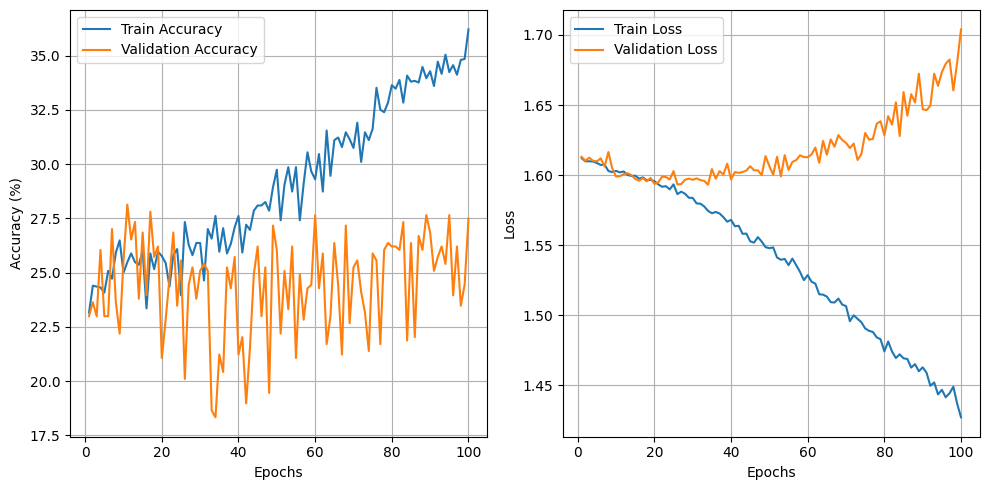

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v3/representacion_1/longitud_8/CNN1D.png')
plt.show()

***Cargar el modelo :***

In [9]:
model.load_state_dict(torch.load("./Modelos/v3/representacion_1/longitud_8/CNN1D_fold_2.pth"))
model.to(device)
model.eval()

CNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

***Evaluar el modelo :***

In [10]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
print(train_df['Type'].unique())         # Ver las clases únicas
print(train_df['Type'].value_counts())   # Ver el conteo de cada clase

***Matriz de confusión :***

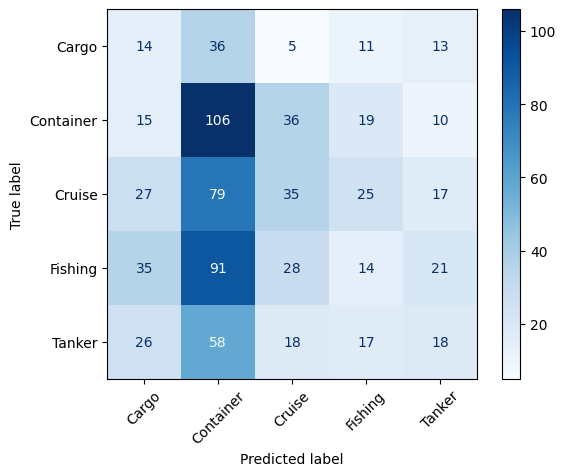

In [11]:
#class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
class_names = ['Cargo', 'Container', 'Cruise', 'Fishing', 'Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [12]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v3/representacion_1/longitud_8')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'CNN1D_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

       Cargo       0.12      0.18      0.14        79
   Container       0.29      0.57      0.38       186
      Cruise       0.29      0.19      0.23       183
     Fishing       0.16      0.07      0.10       189
      Tanker       0.23      0.13      0.17       137

    accuracy                           0.24       774
   macro avg       0.22      0.23      0.20       774
weighted avg       0.23      0.24      0.21       774

